In [1]:
import os
import tensorflow as tf
from efficientnet_v2 import *
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
import pandas as pd
from keras.utils import generic_utils
from efficientnet_v2 import get_preprocessing_layer
from keras import layers
from keras import models
from tensorflow.keras import optimizers

2022-11-22 10:28:05.809188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 10:28:05.911408: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-22 10:28:05.934874: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 10:28:06.368852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## 🚗 Train Fold2-8

- NFold-1

In [2]:
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf_device='/gpu:0'

In [3]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#Setting
BATCH_SIZE = 256
TARGET_SIZE = (480, 480)  # M variant expects images in shape (480, 480)
epochs = 5

In [4]:
#Train
database = pd.read_csv('/media/SSD/Data_photogram_Pcar/Dataset_3DCar.csv') #แก้ data เปลี่ยนตาม fold
trainframe = database[database['Fold'] != 'fold-1'].reset_index(drop=True)
base_dir = '/media/SSD/Data_photogram_Pcar/8-Fold/'
# os.chdir(base_dir)
# train_dir = os.path.join(base_dir, 'train')
print(trainframe.shape)
trainframe.head()

(351635, 11)


Unnamed: 0.1  Unnamed: 0    ID Damage   p  \
0             0           0  id10   Base  p1   
1             1           1  id10   Base  p1   
2             2           2  id10   Base  p1   
3             3           3  id10   Base  p1   
4             4           4  id10   Base  p1   

                                 FileName distance   Angle  \
0    id10-Base_p1_dis1.9_angle0_elev8.png   dis1.9  Angle0   
1  id10-Base_p1_dis1.9_angle0_elev8D1.png   dis1.9  Angle0   
2  id10-Base_p1_dis1.9_angle0_elev8D2.png   dis1.9  Angle0   
3  id10-Base_p1_dis1.9_angle0_elev8D3.png   dis1.9  Angle0   
4  id10-Base_p1_dis1.9_angle0_elev8D4.png   dis1.9  Angle0   

                                            img_path    Fold  \
0  /media/SSD/Data_photogram_car/id10/Base/p1/dis...  fold-4   
1  /media/SSD/Data_photogram_car/id10/Base/p1/dis...  fold-4   
2  /media/SSD/Data_photogram_car/id10/Base/p1/dis...  fold-4   
3  /media/SSD/Data_photogram_car/id10/Base/p1/dis...  fold-4   
4  /media/SSD/Data_photogram_car/id10/Base/p1/dis...  fold-4   

                                          path_train  
0  /media/SSD/Data_photogram_Pcar/8-Fold/id10-Bas...  
1  /media/SSD/Data_photogram_Pcar/8-Fold/id10-Bas...  
2  /media/SSD/Data_photogram_Pcar/8-Fold/id10-Bas...  
3  /media/SSD/Data_photogram_Pcar/8-Fold/id10-Bas...  
4  /media/SSD/Data_photogram_Pcar/8-Fold/id10-Bas...

In [5]:
#validation
testframe = database[database['Fold'] == 'fold-1'].reset_index(drop=True) ###*** เปลี่ยนตาม fold
print(testframe.shape)
testframe.head()

(46332, 11)


Unnamed: 0.1  Unnamed: 0   ID Damage   p  \
0        198383      198383  id2   Base  p1   
1        198384      198384  id2   Base  p1   
2        198385      198385  id2   Base  p1   
3        198386      198386  id2   Base  p1   
4        198387      198387  id2   Base  p1   

                                FileName distance   Angle  \
0    id2-Base_p1_dis1.8_angle0_elev8.png   dis1.8  Angle0   
1  id2-Base_p1_dis1.8_angle0_elev8D1.png   dis1.8  Angle0   
2  id2-Base_p1_dis1.8_angle0_elev8D2.png   dis1.8  Angle0   
3  id2-Base_p1_dis1.8_angle0_elev8D3.png   dis1.8  Angle0   
4  id2-Base_p1_dis1.8_angle0_elev8D4.png   dis1.8  Angle0   

                                            img_path    Fold  \
0  /media/SSD/Data_photogram_car/id2/Base/p1/dis1...  fold-1   
1  /media/SSD/Data_photogram_car/id2/Base/p1/dis1...  fold-1   
2  /media/SSD/Data_photogram_car/id2/Base/p1/dis1...  fold-1   
3  /media/SSD/Data_photogram_car/id2/Base/p1/dis1...  fold-1   
4  /media/SSD/Data_photogram_car/id2/Base/p1/dis1...  fold-1   

                                          path_train  
0  /media/SSD/Data_photogram_Pcar/8-Fold/id2-Base...  
1  /media/SSD/Data_photogram_Pcar/8-Fold/id2-Base...  
2  /media/SSD/Data_photogram_Pcar/8-Fold/id2-Base...  
3  /media/SSD/Data_photogram_Pcar/8-Fold/id2-Base...  
4  /media/SSD/Data_photogram_Pcar/8-Fold/id2-Base...

In [6]:
## Create Model
base_model = EfficientNetV2M(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
                include_top=False, weights="imagenet-21k")  # Let's use pretrained on imagenet 21k and fine tuned on 1k weight variant.
height = width = base_model.input_shape[1]
input_shape = (height, width, 3)

### ****---create new model with a new classification layer
x = base_model.output 
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer_1 = layers.Dropout(0.5,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(15, activation='softmax',name = 'prediction_layer')(dropout_layer_1)  ##15 == Classes 15p

model = models.Model(inputs= base_model.input, outputs=prediction_layer) 
model.summary()

2022-11-22 10:28:30.872737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 10:28:31.679292: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-22 10:28:31.679323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16911 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:65:00.0, compute capability: 8.6
2022-11-22 10:28:31.679841: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWT

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 240, 240, 24  648         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 240, 240, 24  96          ['stem_conv[0][0]']              
                                )                                                             

 )                              )                                0]']                             
                                                                                                  
 block2-02_project_bn (BatchNor  (None, 120, 120, 48  192        ['block2-02_project_conv[0][0]'] 
 malization)                    )                                                                 
                                                                                                  
 block2-02_drop (Dropout)       (None, 120, 120, 48  0           ['block2-02_project_bn[0][0]']   
                                )                                                                 
                                                                                                  
 block2-02_add (Add)            (None, 120, 120, 48  0           ['block2-02_drop[0][0]',         
                                )                                 'block2-01_project_bn[0][0]']   
          

 )                                                               0]']                             
                                                                                                  
 block3-01_project_bn (BatchNor  (None, 60, 60, 80)  320         ['block3-01_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block3-02_expand_conv (Conv2D)  (None, 60, 60, 320)  230400     ['block3-01_project_bn[0][0]']   
                                                                                                  
 block3-02_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block3-02_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block3-02

 block4-01_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block4-01_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block4-01_expand_activation (A  (None, 60, 60, 320)  0          ['block4-01_expand_bn[0][0]']    
 ctivation)                                                                                       
                                                                                                  
 block4-01_dwconv2 (DepthwiseCo  (None, 30, 30, 320)  2880       ['block4-01_expand_activation[0][
 nv2D)                                                           0]']                             
                                                                                                  
 block4-01_bn (BatchNormalizati  (None, 30, 30, 320)  1280       ['block4-01_dwconv2[0][0]']      
 on)      

                                                                                                  
 block4-03_bn (BatchNormalizati  (None, 30, 30, 640)  2560       ['block4-03_dwconv2[0][0]']      
 on)                                                                                              
                                                                                                  
 block4-03_activation (Activati  (None, 30, 30, 640)  0          ['block4-03_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-03_se_squeeze (GlobalAv  (None, 640)         0           ['block4-03_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-03

                                                                                                  
 block4-05_activation (Activati  (None, 30, 30, 640)  0          ['block4-05_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-05_se_squeeze (GlobalAv  (None, 640)         0           ['block4-05_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-05_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-05_se_squeeze[0][0]']   
                                                                                                  
 block4-05_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-05_se_reshape[0][0]']   
          

                                                                                                  
 block4-07_se_squeeze (GlobalAv  (None, 640)         0           ['block4-07_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-07_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-07_se_squeeze[0][0]']   
                                                                                                  
 block4-07_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-07_se_reshape[0][0]']   
                                                                                                  
 block4-07_se_expand (Conv2D)   (None, 1, 1, 640)    26240       ['block4-07_se_reduce[0][0]']    
                                                                                                  
 block4-07

                                                                                                  
 block5-02_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-02_se_reduce[0][0]']    
                                                                                                  
 block5-02_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-02_activation[0][0]',   
                                )                                 'block5-02_se_expand[0][0]']    
                                                                                                  
 block5-02_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-02_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-02_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-02_project_conv[0][0]'] 
 malizatio

 block5-04_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-04_se_reduce[0][0]']    
                                                                                                  
 block5-04_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-04_activation[0][0]',   
                                )                                 'block5-04_se_expand[0][0]']    
                                                                                                  
 block5-04_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-04_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-04_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-04_project_conv[0][0]'] 
 malization)                                                                                      
          

                                                                                                  
 block5-06_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-06_activation[0][0]',   
                                )                                 'block5-06_se_expand[0][0]']    
                                                                                                  
 block5-06_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-06_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-06_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-06_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-06

 block5-08_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-08_activation[0][0]',   
                                )                                 'block5-08_se_expand[0][0]']    
                                                                                                  
 block5-08_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-08_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-08_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-08_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-08_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-08_project_bn[0][0]']   
          

                                )                                 'block5-10_se_expand[0][0]']    
                                                                                                  
 block5-10_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-10_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-10_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-10_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-10_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-10_project_bn[0][0]']   
                                                                                                  
 block5-10

                                                                                                  
 block5-12_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-12_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-12_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-12_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-12_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-12_project_bn[0][0]']   
                                                                                                  
 block5-12_add (Add)            (None, 30, 30, 176)  0           ['block5-12_drop[0][0]',         
          

 block5-14_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-14_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-14_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-14_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-14_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-14_project_bn[0][0]']   
                                                                                                  
 block5-14_add (Add)            (None, 30, 30, 176)  0           ['block5-14_drop[0][0]',         
                                                                  'block5-13_add[0][0]']          
          

 block6-02_drop (Dropout)       (None, 15, 15, 304)  0           ['block6-02_project_bn[0][0]']   
                                                                                                  
 block6-02_add (Add)            (None, 15, 15, 304)  0           ['block6-02_drop[0][0]',         
                                                                  'block6-01_project_bn[0][0]']   
                                                                                                  
 block6-03_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-02_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-03_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-03_expand_conv[0][0]']  
 alization)                     )                                                                 
          

                                                                                                  
 block6-04_add (Add)            (None, 15, 15, 304)  0           ['block6-04_drop[0][0]',         
                                                                  'block6-03_add[0][0]']          
                                                                                                  
 block6-05_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-04_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-05_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-05_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-05

 block6-06_add (Add)            (None, 15, 15, 304)  0           ['block6-06_drop[0][0]',         
                                                                  'block6-05_add[0][0]']          
                                                                                                  
 block6-07_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-06_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-07_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-07_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-07_expand_activation (A  (None, 15, 15, 1824  0          ['block6-07_expand_bn[0][0]']    
 ctivation

                                                                  'block6-07_add[0][0]']          
                                                                                                  
 block6-09_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-08_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-09_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-09_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-09_expand_activation (A  (None, 15, 15, 1824  0          ['block6-09_expand_bn[0][0]']    
 ctivation)                     )                                                                 
          

                                                                                                  
 block6-11_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-10_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-11_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-11_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-11_expand_activation (A  (None, 15, 15, 1824  0          ['block6-11_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-11

 block6-13_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-12_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-13_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-13_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-13_expand_activation (A  (None, 15, 15, 1824  0          ['block6-13_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-13_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-13_expand_activation[0][
 nv2D)    

                                )                                                                 
                                                                                                  
 block6-15_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-15_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-15_expand_activation (A  (None, 15, 15, 1824  0          ['block6-15_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-15_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-15_expand_activation[0][
 nv2D)                          )                                0]']                             
          

                                                                                                  
 block6-17_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-17_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-17_expand_activation (A  (None, 15, 15, 1824  0          ['block6-17_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-17_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-17_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block6-17

 block7-01_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block7-01_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block7-01_expand_activation (A  (None, 15, 15, 1824  0          ['block7-01_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block7-01_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block7-01_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-01_bn (BatchNormalizati  (None, 15, 15, 1824  7296       ['block7-01_dwconv2[0][0]']      
 on)      

 block7-03_dwconv2 (DepthwiseCo  (None, 15, 15, 3072  27648      ['block7-03_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-03_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-03_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-03_activation (Activati  (None, 15, 15, 3072  0          ['block7-03_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-03_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-03_activation[0][0]']   
 eragePool

 nv2D)                          )                                0]']                             
                                                                                                  
 block7-05_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-05_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-05_activation (Activati  (None, 15, 15, 3072  0          ['block7-05_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-05_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-05_activation[0][0]']   
 eragePooling2D)                                                                                  
          

In [7]:
##Freeze
print('This is the number of trainable layers '
          'before freezing the conv base:', len(model.trainable_weights))
for layer in base_model.layers:
    layer.trainable = False
print('This is the number of trainable layers '
          'after freezing the conv base:', len(model.trainable_weights))
print('-'*80)

This is the number of trainable layers before freezing the conv base: 649
This is the number of trainable layers after freezing the conv base: 2
--------------------------------------------------------------------------------


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 240, 240, 24  648         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 240, 240, 24  96          ['stem_conv[0][0]']              
                                )                                                             

 )                              )                                0]']                             
                                                                                                  
 block2-02_project_bn (BatchNor  (None, 120, 120, 48  192        ['block2-02_project_conv[0][0]'] 
 malization)                    )                                                                 
                                                                                                  
 block2-02_drop (Dropout)       (None, 120, 120, 48  0           ['block2-02_project_bn[0][0]']   
                                )                                                                 
                                                                                                  
 block2-02_add (Add)            (None, 120, 120, 48  0           ['block2-02_drop[0][0]',         
                                )                                 'block2-01_project_bn[0][0]']   
          

 )                                                               0]']                             
                                                                                                  
 block3-01_project_bn (BatchNor  (None, 60, 60, 80)  320         ['block3-01_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block3-02_expand_conv (Conv2D)  (None, 60, 60, 320)  230400     ['block3-01_project_bn[0][0]']   
                                                                                                  
 block3-02_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block3-02_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block3-02

 block4-01_expand_bn (BatchNorm  (None, 60, 60, 320)  1280       ['block4-01_expand_conv[0][0]']  
 alization)                                                                                       
                                                                                                  
 block4-01_expand_activation (A  (None, 60, 60, 320)  0          ['block4-01_expand_bn[0][0]']    
 ctivation)                                                                                       
                                                                                                  
 block4-01_dwconv2 (DepthwiseCo  (None, 30, 30, 320)  2880       ['block4-01_expand_activation[0][
 nv2D)                                                           0]']                             
                                                                                                  
 block4-01_bn (BatchNormalizati  (None, 30, 30, 320)  1280       ['block4-01_dwconv2[0][0]']      
 on)      

                                                                                                  
 block4-03_bn (BatchNormalizati  (None, 30, 30, 640)  2560       ['block4-03_dwconv2[0][0]']      
 on)                                                                                              
                                                                                                  
 block4-03_activation (Activati  (None, 30, 30, 640)  0          ['block4-03_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-03_se_squeeze (GlobalAv  (None, 640)         0           ['block4-03_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-03

                                                                                                  
 block4-05_activation (Activati  (None, 30, 30, 640)  0          ['block4-05_bn[0][0]']           
 on)                                                                                              
                                                                                                  
 block4-05_se_squeeze (GlobalAv  (None, 640)         0           ['block4-05_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-05_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-05_se_squeeze[0][0]']   
                                                                                                  
 block4-05_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-05_se_reshape[0][0]']   
          

                                                                                                  
 block4-07_se_squeeze (GlobalAv  (None, 640)         0           ['block4-07_activation[0][0]']   
 eragePooling2D)                                                                                  
                                                                                                  
 block4-07_se_reshape (Reshape)  (None, 1, 1, 640)   0           ['block4-07_se_squeeze[0][0]']   
                                                                                                  
 block4-07_se_reduce (Conv2D)   (None, 1, 1, 40)     25640       ['block4-07_se_reshape[0][0]']   
                                                                                                  
 block4-07_se_expand (Conv2D)   (None, 1, 1, 640)    26240       ['block4-07_se_reduce[0][0]']    
                                                                                                  
 block4-07

                                                                                                  
 block5-02_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-02_se_reduce[0][0]']    
                                                                                                  
 block5-02_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-02_activation[0][0]',   
                                )                                 'block5-02_se_expand[0][0]']    
                                                                                                  
 block5-02_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-02_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-02_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-02_project_conv[0][0]'] 
 malizatio

 block5-04_se_expand (Conv2D)   (None, 1, 1, 1056)   47520       ['block5-04_se_reduce[0][0]']    
                                                                                                  
 block5-04_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-04_activation[0][0]',   
                                )                                 'block5-04_se_expand[0][0]']    
                                                                                                  
 block5-04_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-04_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-04_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-04_project_conv[0][0]'] 
 malization)                                                                                      
          

                                                                                                  
 block5-06_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-06_activation[0][0]',   
                                )                                 'block5-06_se_expand[0][0]']    
                                                                                                  
 block5-06_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-06_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-06_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-06_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-06

 block5-08_se_excite (Multiply)  (None, 30, 30, 1056  0          ['block5-08_activation[0][0]',   
                                )                                 'block5-08_se_expand[0][0]']    
                                                                                                  
 block5-08_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-08_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-08_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-08_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-08_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-08_project_bn[0][0]']   
          

                                )                                 'block5-10_se_expand[0][0]']    
                                                                                                  
 block5-10_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-10_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-10_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-10_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-10_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-10_project_bn[0][0]']   
                                                                                                  
 block5-10

                                                                                                  
 block5-12_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-12_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-12_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-12_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-12_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-12_project_bn[0][0]']   
                                                                                                  
 block5-12_add (Add)            (None, 30, 30, 176)  0           ['block5-12_drop[0][0]',         
          

 block5-14_project_conv (Conv2D  (None, 30, 30, 176)  185856     ['block5-14_se_excite[0][0]']    
 )                                                                                                
                                                                                                  
 block5-14_project_bn (BatchNor  (None, 30, 30, 176)  704        ['block5-14_project_conv[0][0]'] 
 malization)                                                                                      
                                                                                                  
 block5-14_drop (Dropout)       (None, 30, 30, 176)  0           ['block5-14_project_bn[0][0]']   
                                                                                                  
 block5-14_add (Add)            (None, 30, 30, 176)  0           ['block5-14_drop[0][0]',         
                                                                  'block5-13_add[0][0]']          
          

 block6-02_drop (Dropout)       (None, 15, 15, 304)  0           ['block6-02_project_bn[0][0]']   
                                                                                                  
 block6-02_add (Add)            (None, 15, 15, 304)  0           ['block6-02_drop[0][0]',         
                                                                  'block6-01_project_bn[0][0]']   
                                                                                                  
 block6-03_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-02_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-03_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-03_expand_conv[0][0]']  
 alization)                     )                                                                 
          

                                                                                                  
 block6-04_add (Add)            (None, 15, 15, 304)  0           ['block6-04_drop[0][0]',         
                                                                  'block6-03_add[0][0]']          
                                                                                                  
 block6-05_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-04_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-05_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-05_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-05

 block6-06_add (Add)            (None, 15, 15, 304)  0           ['block6-06_drop[0][0]',         
                                                                  'block6-05_add[0][0]']          
                                                                                                  
 block6-07_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-06_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-07_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-07_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-07_expand_activation (A  (None, 15, 15, 1824  0          ['block6-07_expand_bn[0][0]']    
 ctivation

                                                                  'block6-07_add[0][0]']          
                                                                                                  
 block6-09_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-08_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-09_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-09_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-09_expand_activation (A  (None, 15, 15, 1824  0          ['block6-09_expand_bn[0][0]']    
 ctivation)                     )                                                                 
          

                                                                                                  
 block6-11_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-10_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-11_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-11_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-11_expand_activation (A  (None, 15, 15, 1824  0          ['block6-11_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-11

 block6-13_expand_conv (Conv2D)  (None, 15, 15, 1824  554496     ['block6-12_add[0][0]']          
                                )                                                                 
                                                                                                  
 block6-13_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-13_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-13_expand_activation (A  (None, 15, 15, 1824  0          ['block6-13_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-13_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-13_expand_activation[0][
 nv2D)    

                                )                                                                 
                                                                                                  
 block6-15_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-15_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-15_expand_activation (A  (None, 15, 15, 1824  0          ['block6-15_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-15_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-15_expand_activation[0][
 nv2D)                          )                                0]']                             
          

                                                                                                  
 block6-17_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block6-17_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block6-17_expand_activation (A  (None, 15, 15, 1824  0          ['block6-17_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block6-17_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block6-17_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block6-17

 block7-01_expand_bn (BatchNorm  (None, 15, 15, 1824  7296       ['block7-01_expand_conv[0][0]']  
 alization)                     )                                                                 
                                                                                                  
 block7-01_expand_activation (A  (None, 15, 15, 1824  0          ['block7-01_expand_bn[0][0]']    
 ctivation)                     )                                                                 
                                                                                                  
 block7-01_dwconv2 (DepthwiseCo  (None, 15, 15, 1824  16416      ['block7-01_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-01_bn (BatchNormalizati  (None, 15, 15, 1824  7296       ['block7-01_dwconv2[0][0]']      
 on)      

 block7-03_dwconv2 (DepthwiseCo  (None, 15, 15, 3072  27648      ['block7-03_expand_activation[0][
 nv2D)                          )                                0]']                             
                                                                                                  
 block7-03_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-03_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-03_activation (Activati  (None, 15, 15, 3072  0          ['block7-03_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-03_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-03_activation[0][0]']   
 eragePool

 nv2D)                          )                                0]']                             
                                                                                                  
 block7-05_bn (BatchNormalizati  (None, 15, 15, 3072  12288      ['block7-05_dwconv2[0][0]']      
 on)                            )                                                                 
                                                                                                  
 block7-05_activation (Activati  (None, 15, 15, 3072  0          ['block7-05_bn[0][0]']           
 on)                            )                                                                 
                                                                                                  
 block7-05_se_squeeze (GlobalAv  (None, 3072)        0           ['block7-05_activation[0][0]']   
 eragePooling2D)                                                                                  
          

In [9]:
## Create Data Loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.25,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = trainframe,
        directory = None ,
        x_col = 'img_path',
        y_col = 'p',
        subset="training",
        target_size = (height, width),
        batch_size=BATCH_SIZE,
        color_mode= 'rgb',
        shuffle=True,
        class_mode='categorical')

valid_generator = train_datagen.flow_from_dataframe(
        dataframe = trainframe,
        directory = None ,
        x_col = 'img_path',
        y_col = 'p',
        subset="validation",
        target_size = (height, width),
        batch_size=BATCH_SIZE,
        color_mode= 'rgb',
        shuffle=True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe = testframe,
        directory = None,
        x_col = 'img_path',
        y_col = 'p',
        target_size = (height, width),
        batch_size=BATCH_SIZE,
        shuffle=False,
        color_mode= 'rgb',
        class_mode='categorical')

Found 263727 validated image filenames belonging to 15 classes.
Found 87908 validated image filenames belonging to 15 classes.
Found 46332 validated image filenames belonging to 13 classes.


### 🗃️ Check Image

In [10]:
train_generator

In [12]:
files=train_generator.filenames
class_dict=test_generator.class_indices # a dictionary of the form class name: class index
rev_dict={}
for key, value in class_dict.items():
    rev_dict[value]=key  

In [14]:
print(len(files))
files

263727


['/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L3/id12-Severe_p10_dis1.65O2_angle253L3_elev35U4.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35D1.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35D2.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35D3.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35D4.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35U1.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35U2.png',
 '/media/SSD/Data_photogram_car/id

In [15]:
class_dict

{'p1': 0,
 'p11': 1,
 'p12': 2,
 'p13': 3,
 'p14': 4,
 'p15': 5,
 'p2': 6,
 'p3': 7,
 'p4': 8,
 'p5': 9,
 'p6': 10,
 'p7': 11,
 'p8': 12}

['/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L3/id12-Severe_p10_dis1.65O2_angle253L3_elev35U4.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35D1.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35D2.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35D3.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35D4.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35U1.png',
 '/media/SSD/Data_photogram_car/id12/Severe/p10/dis1.65O2/Angle253L4/id12-Severe_p10_dis1.65O2_angle253L4_elev35U2.png',
 '/media/SSD/Data_photogram_car/id

In [ ]:
for image_batch, labels_batch in train_generator:
    print(image_batch.filenames)
#files=train_generator.filenames

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: 'DataFrameIterator' object has no attribute 'take'

<Figure size 1000x1000 with 0 Axes>

In [21]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(256, 480, 480, 3)
(256, 15)


In [42]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)

(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480, 3)
(256, 15)
(256, 480, 480

KeyboardInterrupt: 

In [ ]:
image_batch

In [22]:
image_batch

array([[[[0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         ...,
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ]],

        [[0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         ...,
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ]],

        [[0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         ...,
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ]],

        ...,

        [[0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065]

In [23]:
print(len(image_batch))
image_batch

256


array([[[[0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         ...,
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ]],

        [[0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         ...,
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ]],

        [[0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065],
         ...,
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ],
         [0.27450982, 0.04705883, 0.3372549 ]],

        ...,

        [[0.97647065, 0.97647065, 0.97647065],
         [0.97647065, 0.97647065, 0.97647065]

In [25]:
image_batch[0]

array([[[0.97647065, 0.97647065, 0.97647065],
        [0.97647065, 0.97647065, 0.97647065],
        [0.97647065, 0.97647065, 0.97647065],
        ...,
        [0.27450982, 0.04705883, 0.3372549 ],
        [0.27450982, 0.04705883, 0.3372549 ],
        [0.27450982, 0.04705883, 0.3372549 ]],

       [[0.97647065, 0.97647065, 0.97647065],
        [0.97647065, 0.97647065, 0.97647065],
        [0.97647065, 0.97647065, 0.97647065],
        ...,
        [0.27450982, 0.04705883, 0.3372549 ],
        [0.27450982, 0.04705883, 0.3372549 ],
        [0.27450982, 0.04705883, 0.3372549 ]],

       [[0.97647065, 0.97647065, 0.97647065],
        [0.97647065, 0.97647065, 0.97647065],
        [0.97647065, 0.97647065, 0.97647065],
        ...,
        [0.27450982, 0.04705883, 0.3372549 ],
        [0.27450982, 0.04705883, 0.3372549 ],
        [0.27450982, 0.04705883, 0.3372549 ]],

       ...,

       [[0.97647065, 0.97647065, 0.97647065],
        [0.97647065, 0.97647065, 0.97647065],
        [0.97647065, 0

In [34]:
len(image_batch[0])

480

In [48]:
len_ = []
for images in image_batch[2]:
    if len(images) < 1 :
        len_.append(images)

In [49]:
print(len(len_))

0


In [38]:
images

array([[[0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        ...,
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ]],

       [[0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        ...,
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ]],

       [[0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        ...,
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.5686275 , 0.5686275 , 0.5686275 ]],

       ...,

       [[0.23529413, 0.16862746, 0.2509804 ],
        [0.23529413, 0.16862746, 0.2509804 ],
        [0.23529413, 0

In [41]:
result = train_generator.map(lambda image, label: image)
# You can iterate and check what you have received at the end.
# I expect only the images.
for image in result.take(1):
    print(image)

AttributeError: 'DataFrameIterator' object has no attribute 'map'

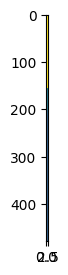

/tmp/ipykernel_46745/4031053764.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i + 1)


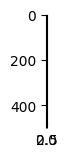

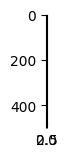

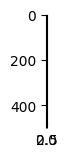

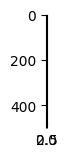

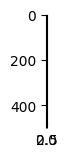

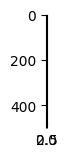

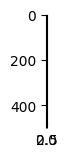

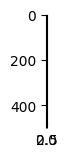

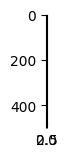

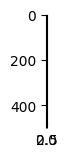

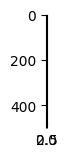

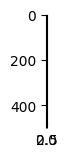

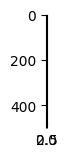

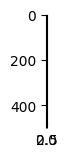

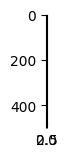

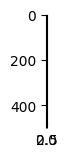

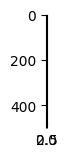

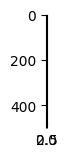

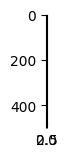

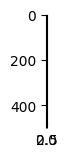

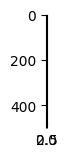

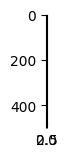

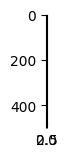

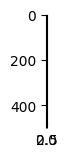

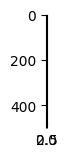

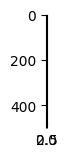

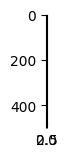

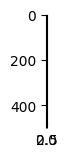

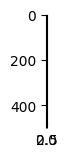

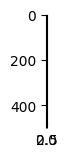

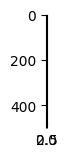

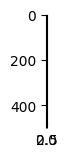

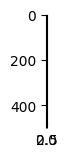

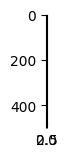

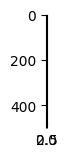

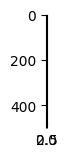

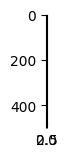

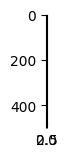

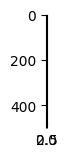

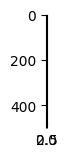

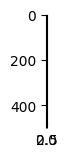

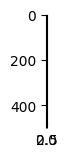

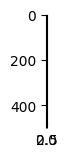

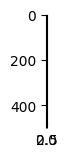

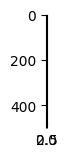

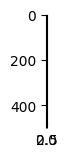

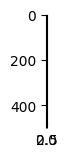

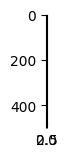

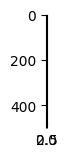

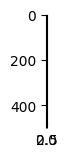

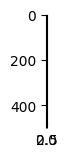

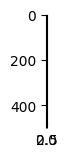

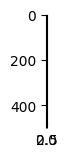

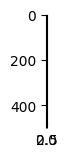

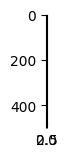

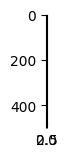

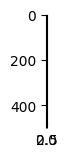

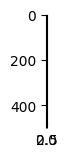

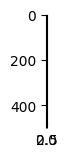

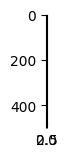

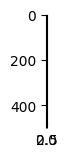

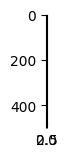

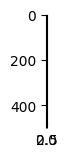

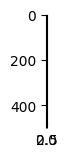

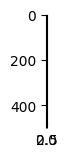

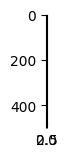

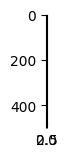

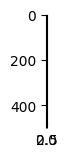

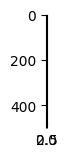

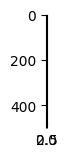

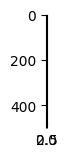

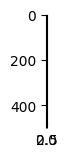

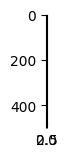

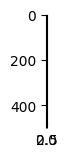

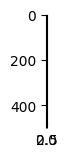

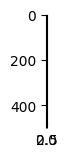

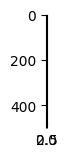

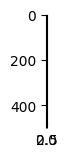

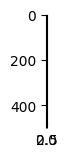

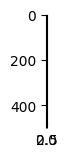

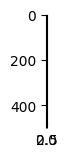

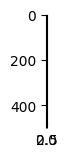

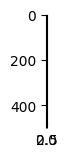

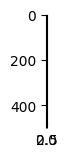

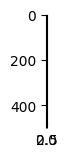

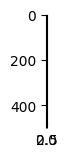

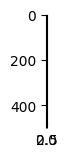

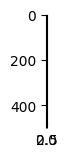

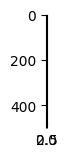

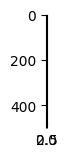

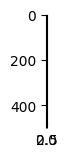

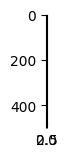

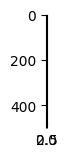

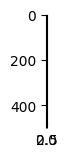

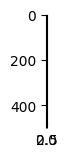

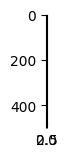

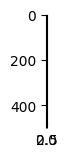

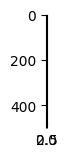

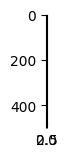

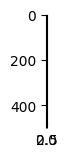

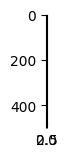

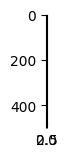

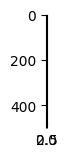

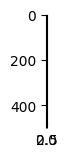

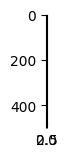

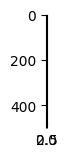

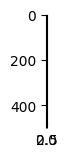

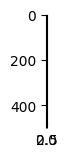

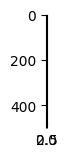

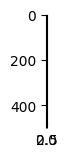

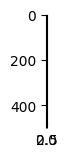

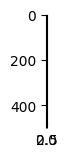

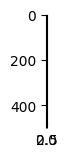

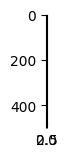

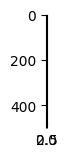

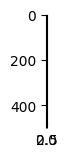

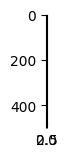

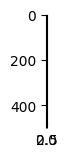

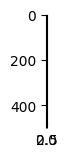

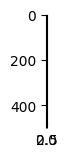

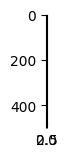

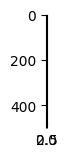

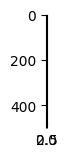

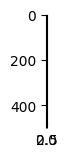

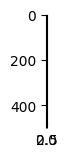

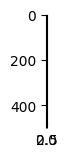

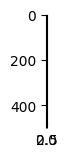

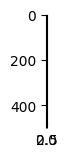

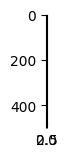

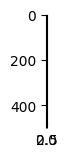

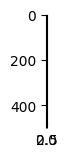

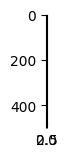

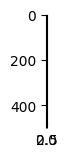

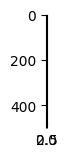

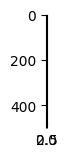

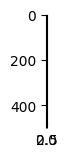

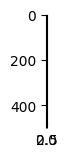

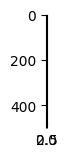

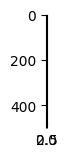

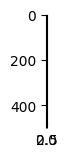

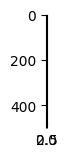

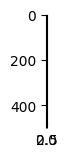

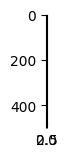

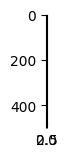

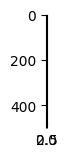

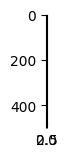

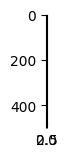

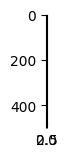

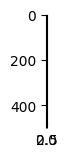

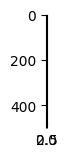

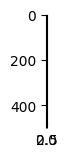

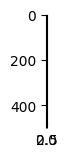

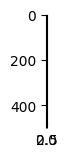

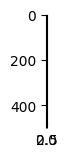

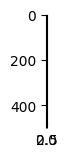

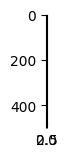

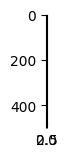

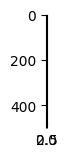

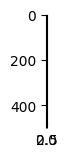

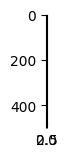

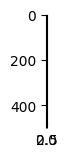

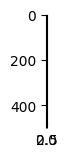

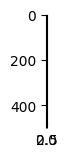

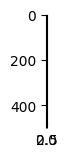

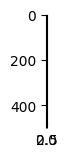

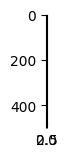

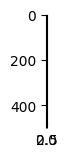

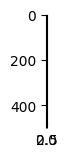

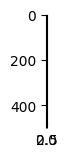

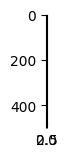

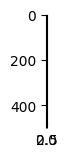

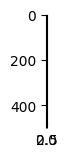

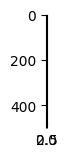

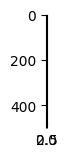

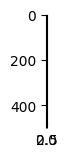

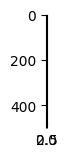

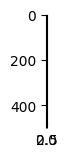

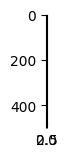

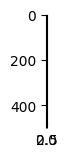

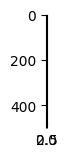

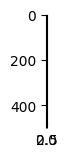

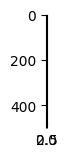

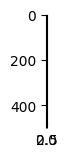

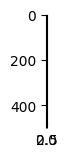

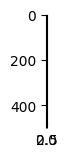

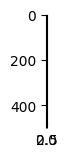

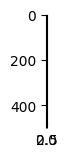

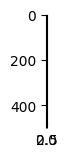

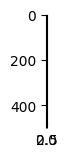

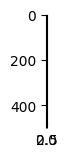

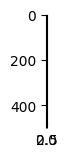

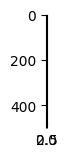

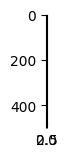

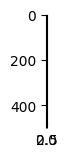

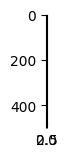

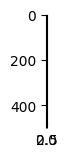

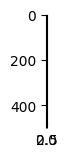

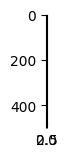

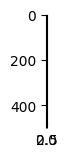

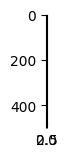

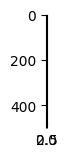

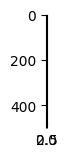

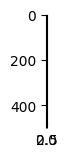

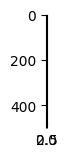

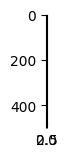

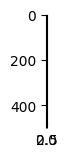

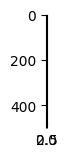

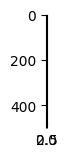

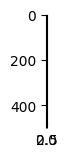

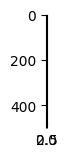

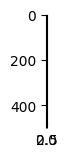

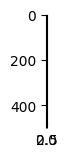

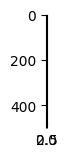

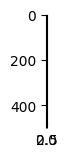

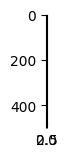

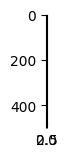

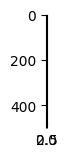

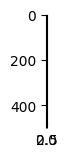

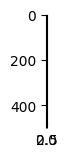

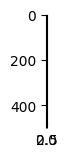

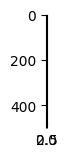

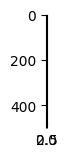

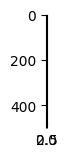

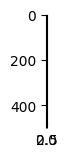

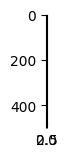

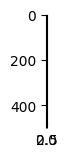

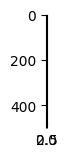

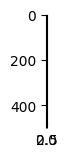

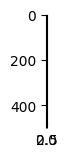

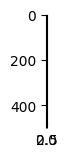

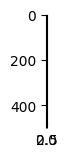

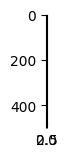

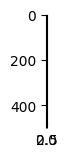

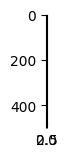

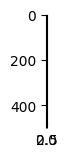

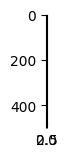

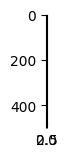

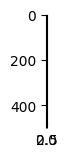

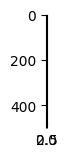

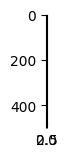

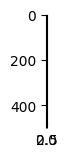

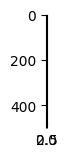

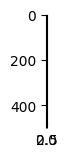

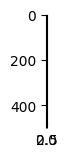

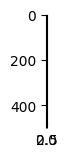

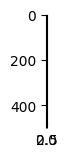

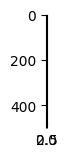

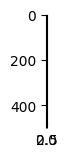

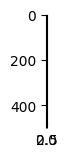

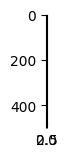

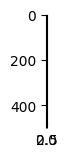

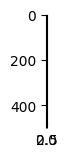

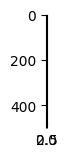

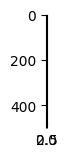

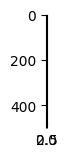

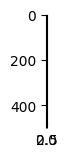

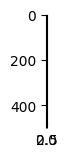

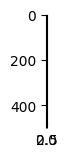

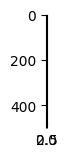

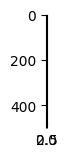

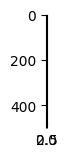

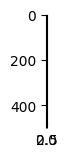

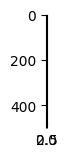

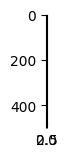

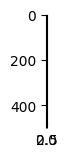

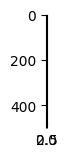

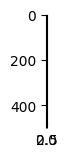

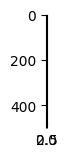

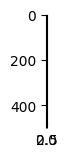

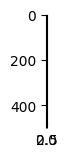

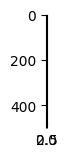

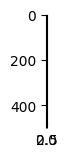

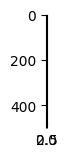

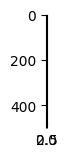

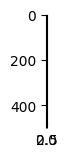

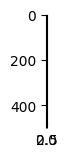

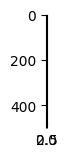

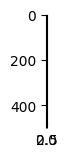

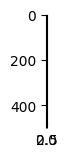

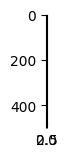

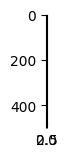

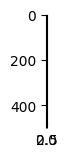

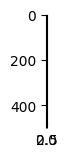

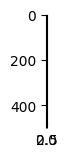

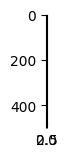

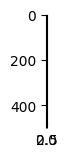

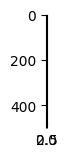

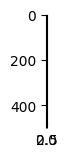

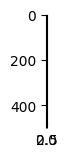

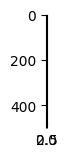

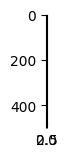

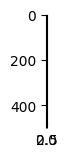

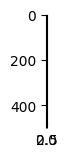

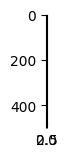

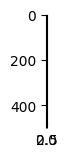

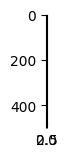

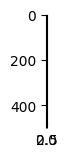

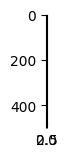

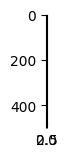

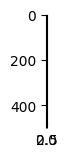

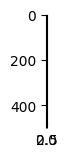

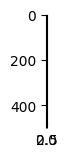

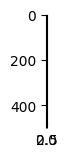

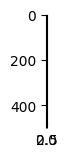

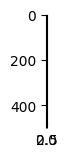

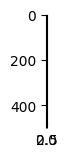

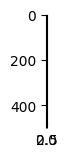

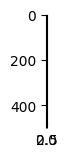

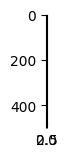

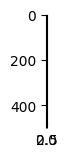

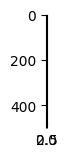

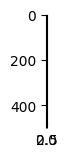

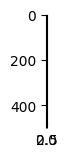

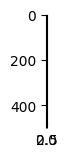

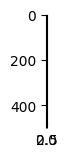

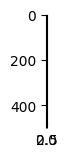

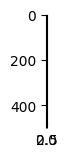

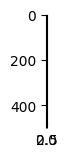

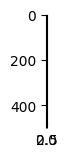

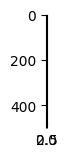

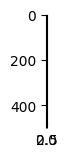

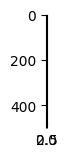

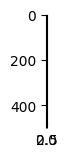

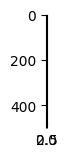

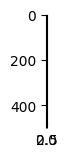

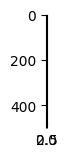

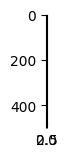

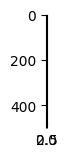

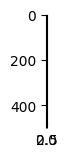

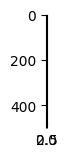

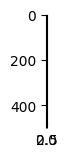

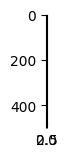

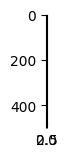

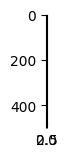

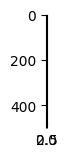

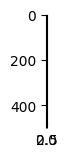

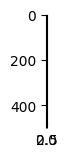

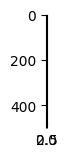

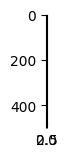

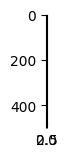

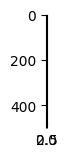

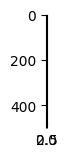

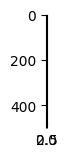

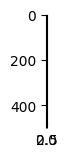

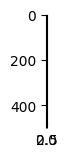

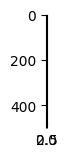

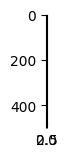

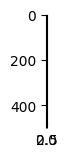

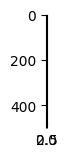

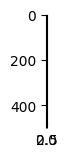

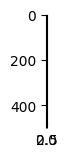

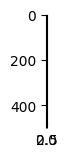

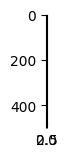

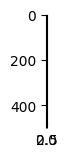

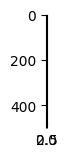

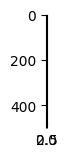

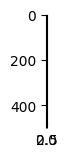

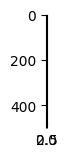

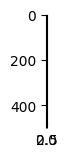

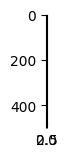

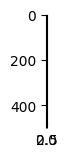

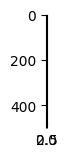

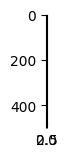

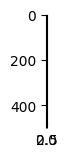

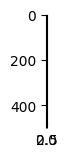

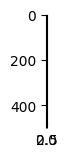

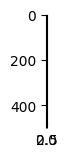

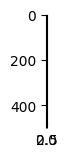

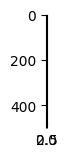

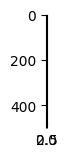

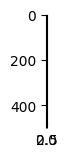

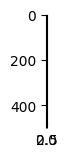

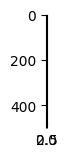

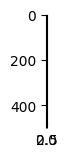

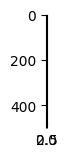

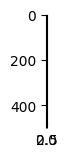

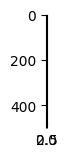

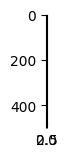

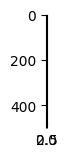

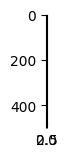

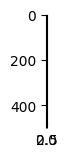

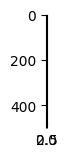

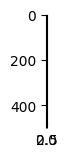

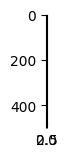

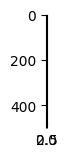

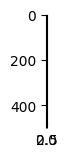

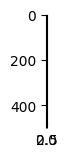

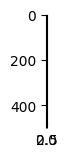

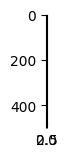

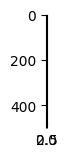

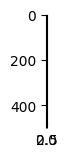

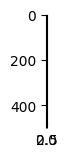

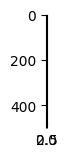

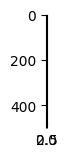

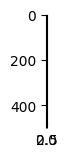

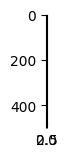

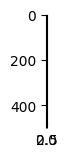

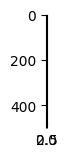

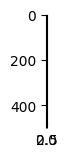

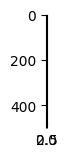

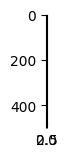

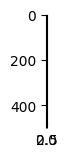

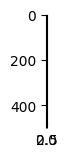

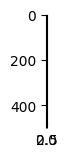

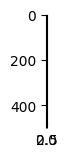

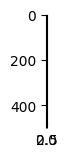

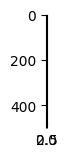

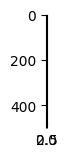

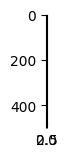

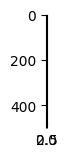

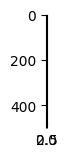

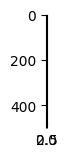

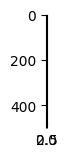

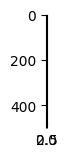

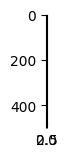

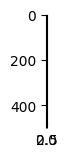

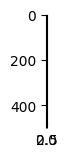

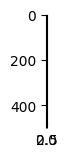

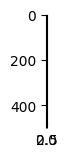

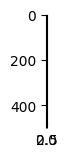

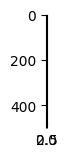

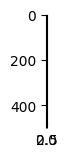

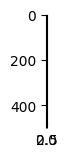

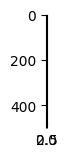

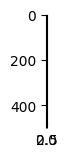

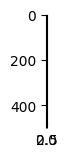

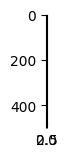

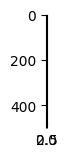

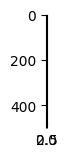

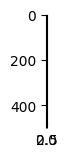

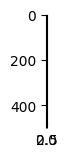

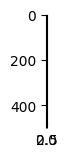

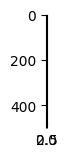

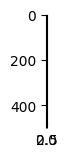

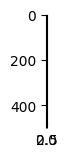

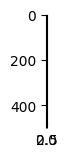

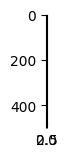

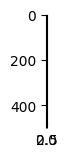

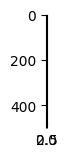

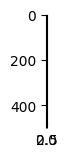

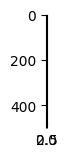

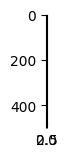

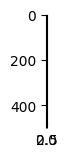

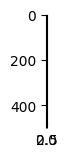

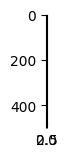

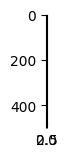

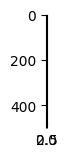

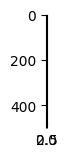

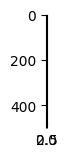

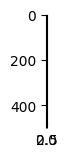

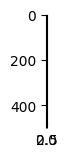

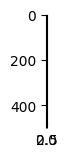

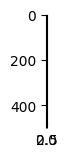

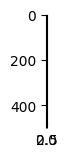

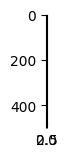

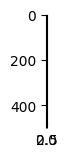

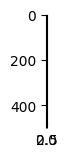

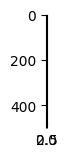

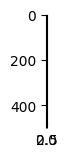

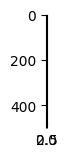

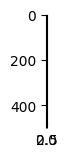

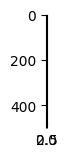

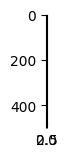

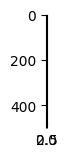

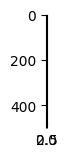

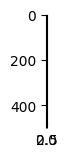

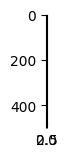

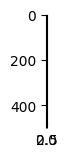

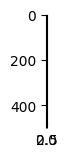

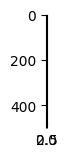

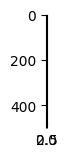

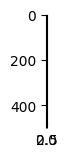

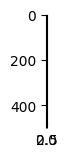

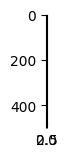

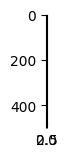

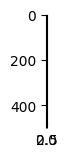

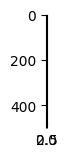

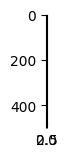

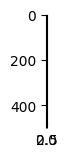

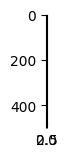

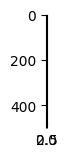

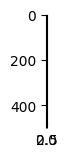

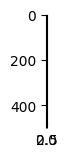

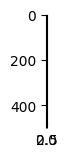

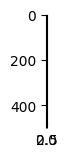

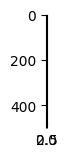

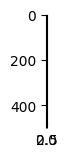

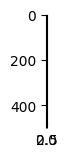

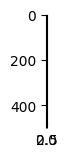

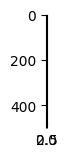

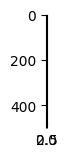

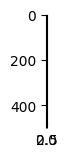

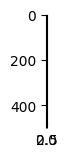

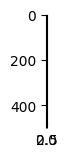

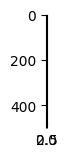

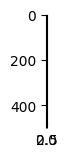

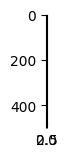

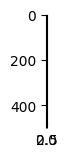

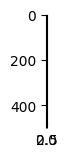

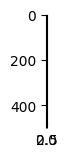

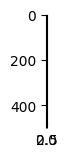

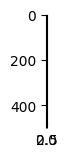

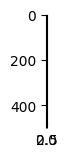

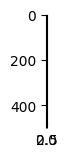

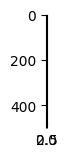

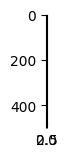

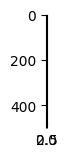

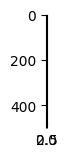

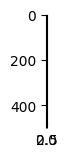

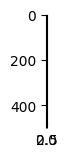

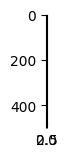

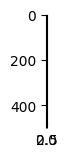

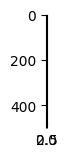

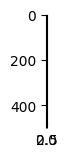

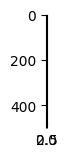

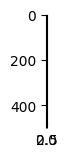

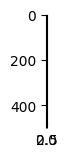

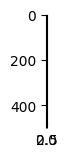

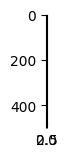

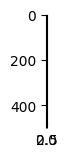

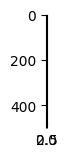

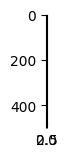

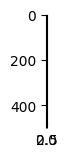

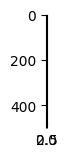

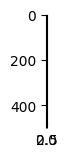

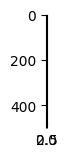

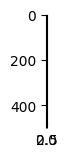

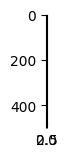

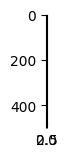

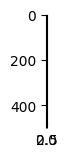

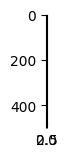

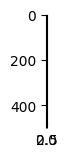

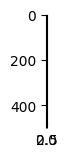

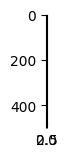

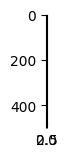

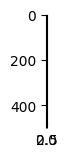

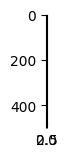

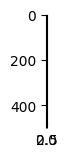

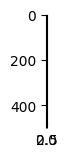

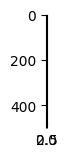

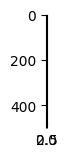

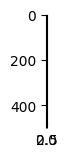

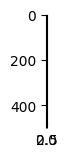

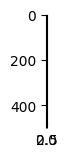

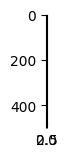

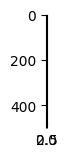

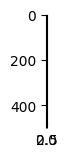

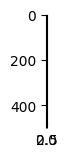

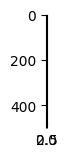

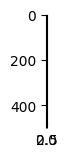

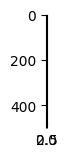

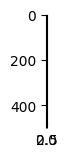

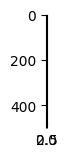

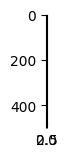

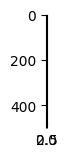

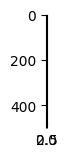

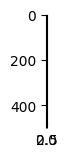

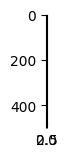

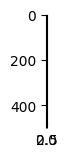

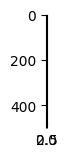

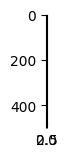

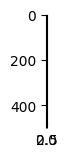

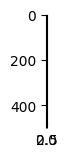

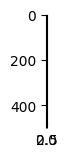

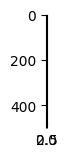

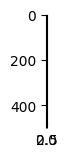

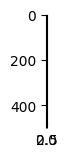

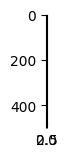

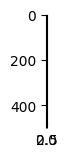

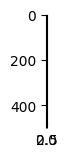

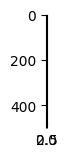

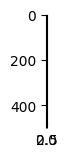

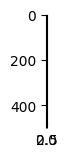

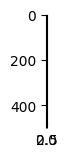

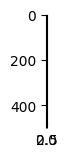

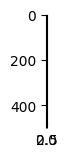

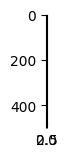

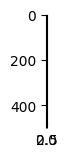

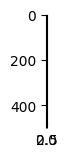

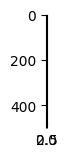

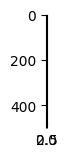

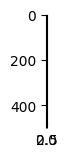

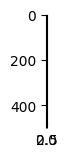

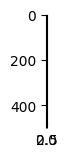

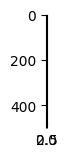

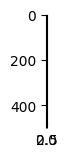

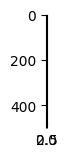

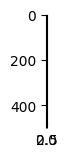

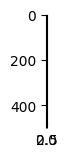

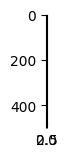

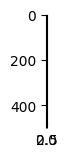

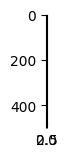

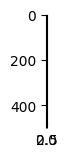

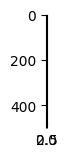

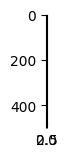

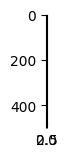

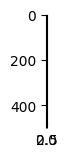

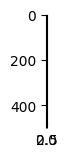

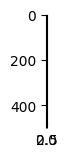

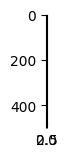

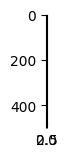

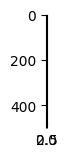

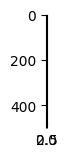

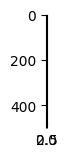

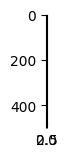

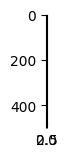

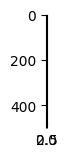

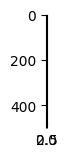

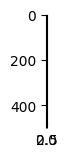

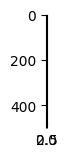

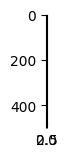

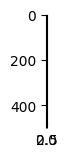

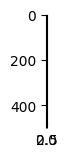

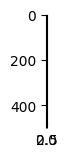

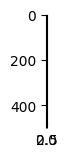

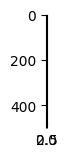

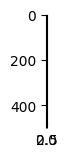

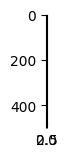

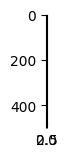

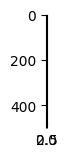

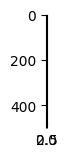

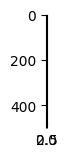

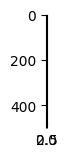

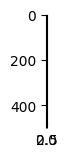

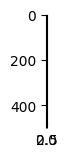

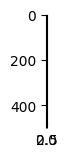

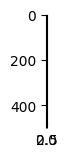

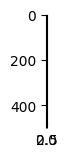

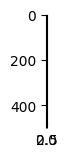

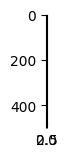

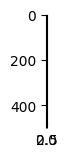

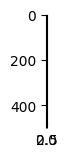

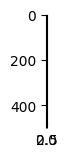

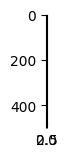

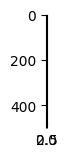

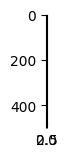

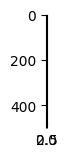

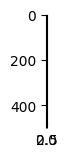

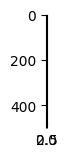

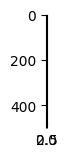

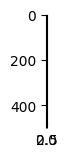

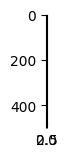

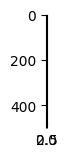

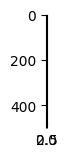

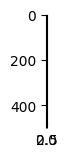

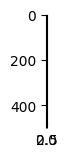

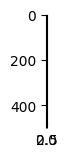

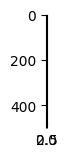

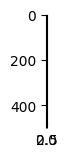

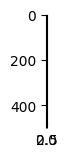

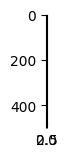

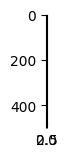

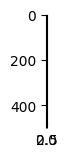

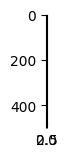

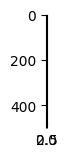

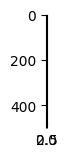

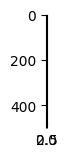

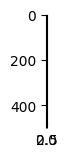

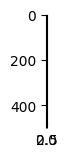

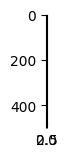

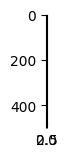

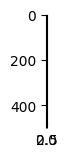

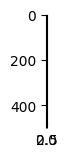

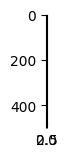

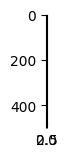

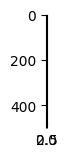

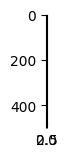

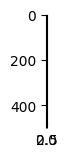

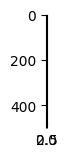

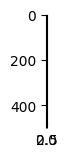

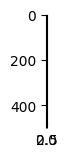

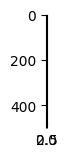

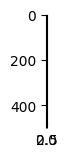

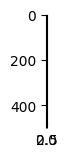

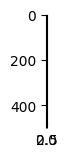

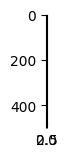

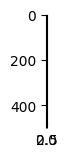

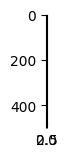

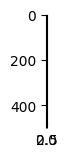

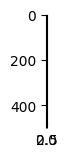

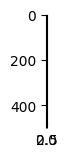

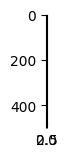

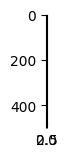

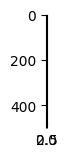

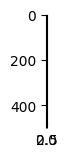

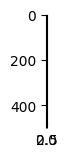

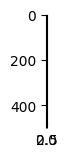

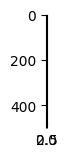

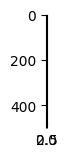

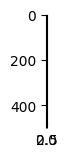

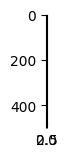

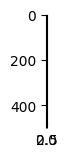

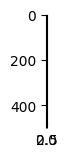

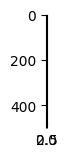

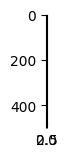

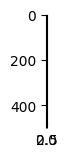

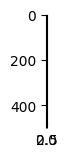

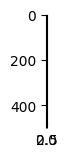

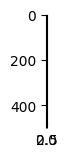

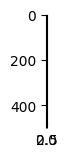

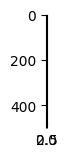

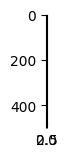

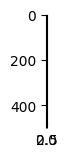

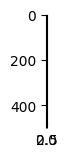

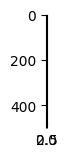

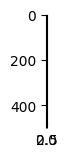

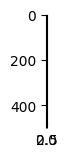

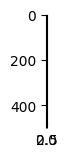

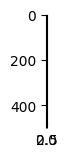

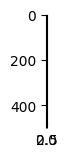

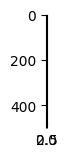

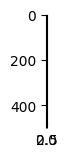

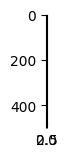

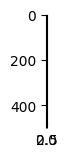

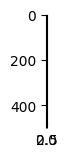

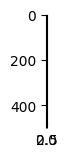

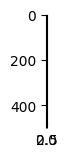

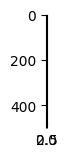

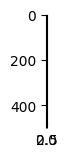

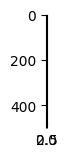

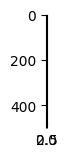

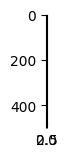

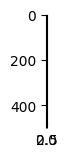

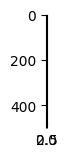

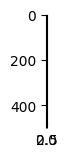

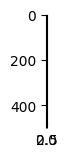

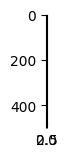

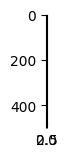

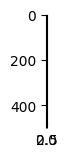

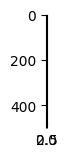

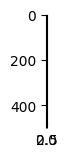

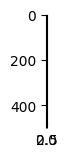

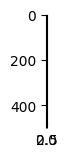

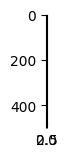

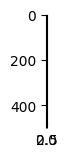

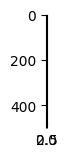

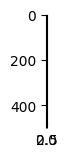

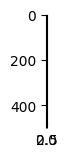

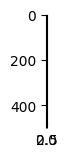

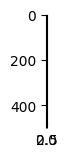

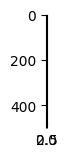

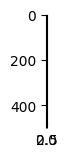

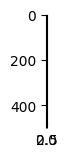

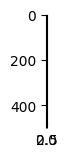

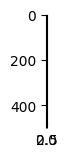

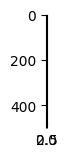

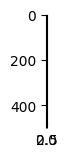

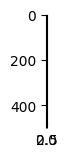

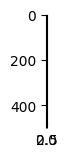

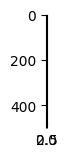

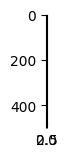

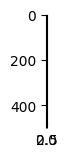

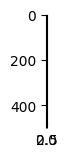

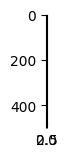

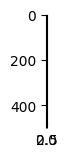

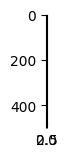

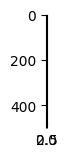

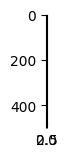

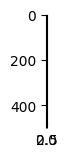

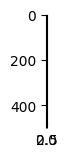

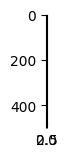

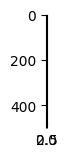

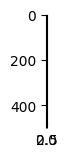

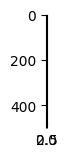

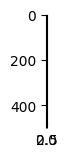

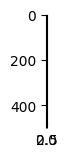

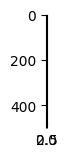

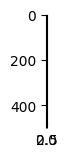

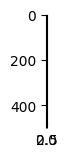

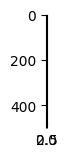

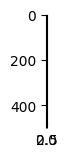

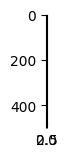

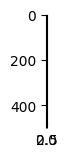

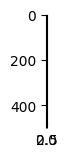

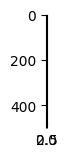

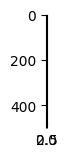

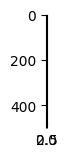

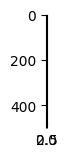

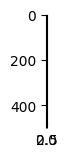

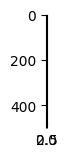

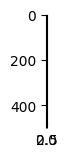

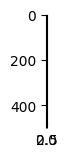

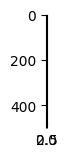

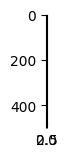

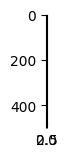

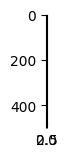

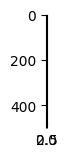

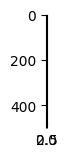

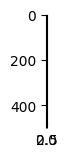

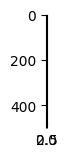

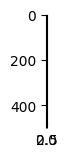

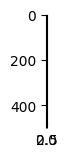

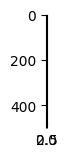

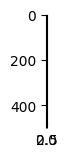

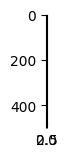

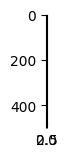

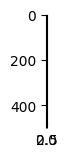

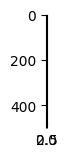

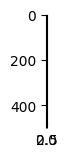

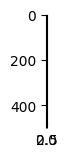

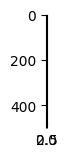

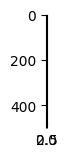

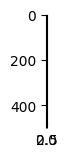

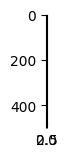

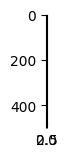

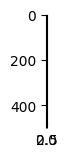

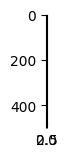

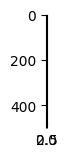

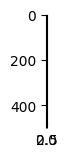

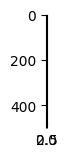

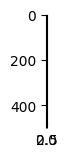

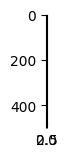

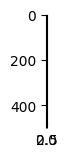

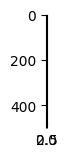

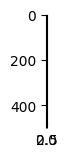

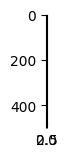

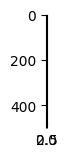

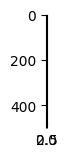

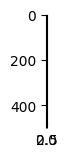

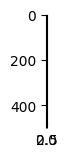

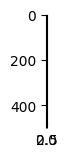

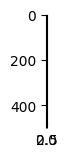

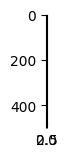

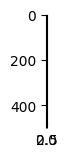

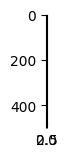

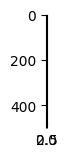

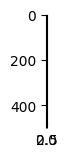

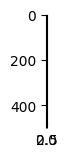

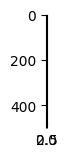

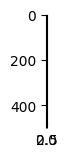

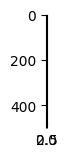

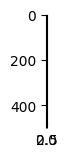

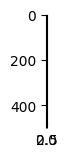

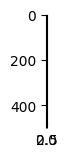

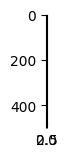

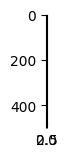

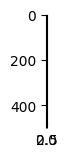

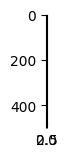

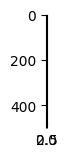

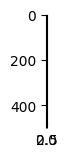

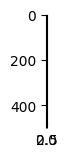

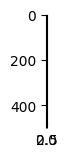

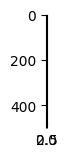

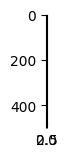

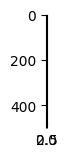

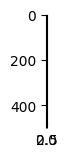

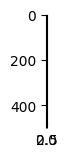

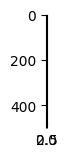

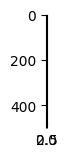

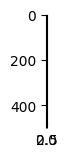

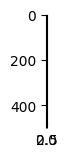

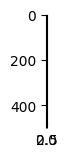

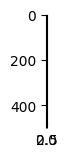

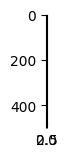

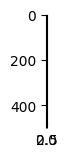

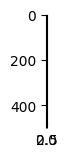

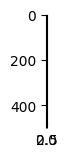

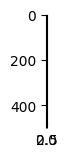

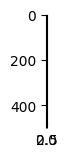

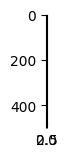

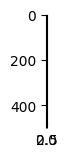

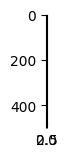

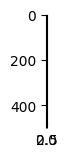

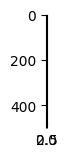

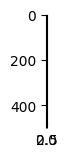

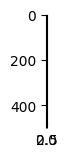

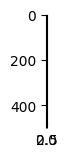

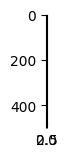

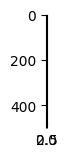

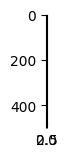

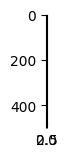

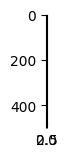

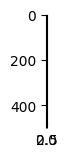

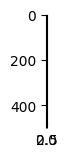

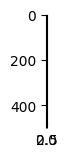

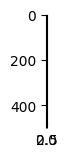

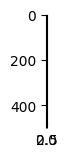

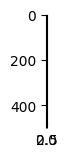

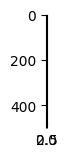

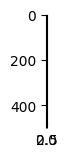

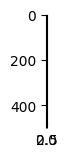

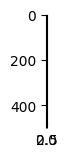

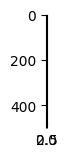

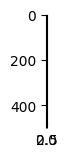

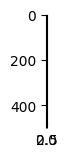

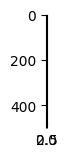

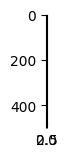

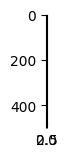

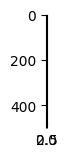

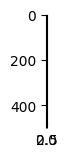

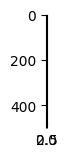

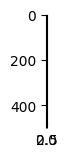

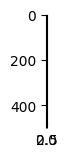

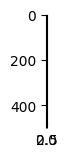

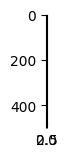

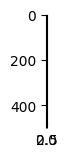

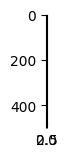

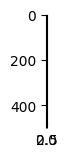

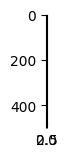

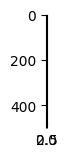

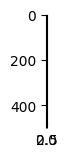

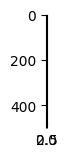

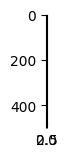

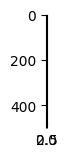

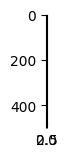

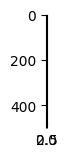

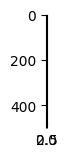

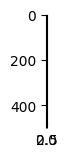

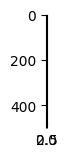

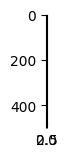

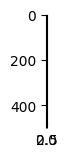

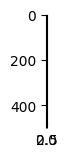

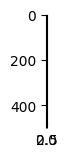

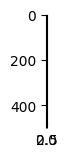

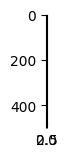

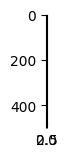

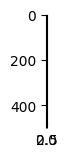

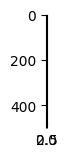

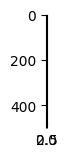

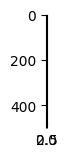

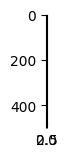

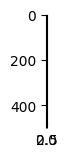

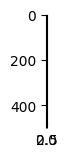

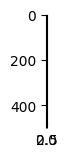

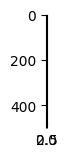

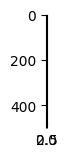

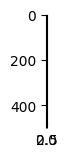

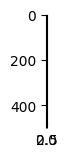

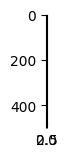

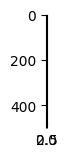

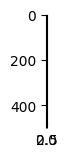

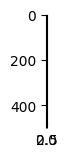

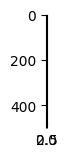

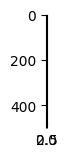

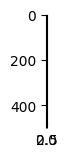

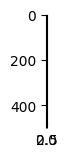

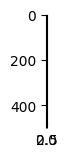

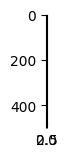

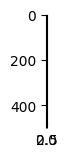

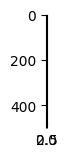

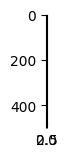

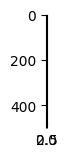

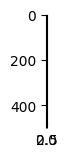

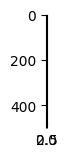

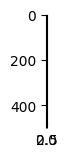

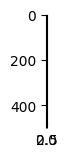

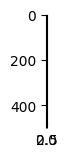

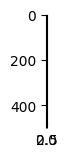

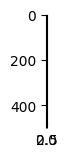

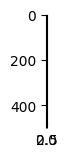

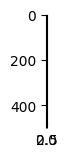

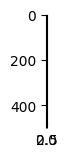

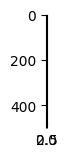

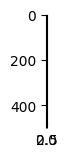

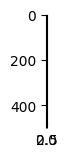

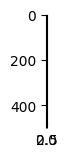

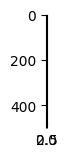

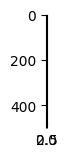

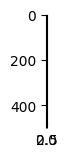

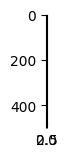

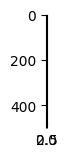

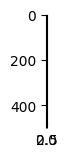

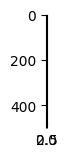

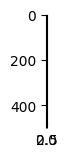

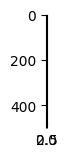

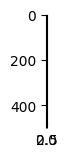

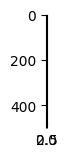

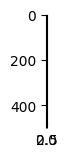

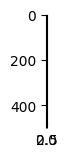

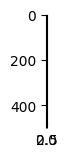

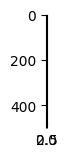

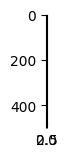

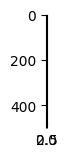

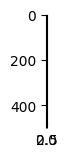

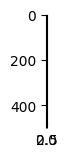

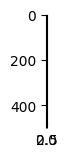

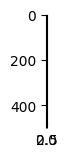

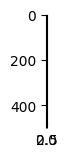

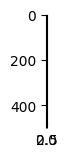

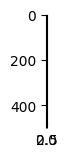

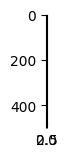

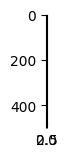

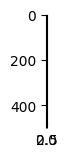

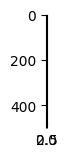

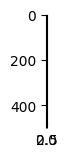

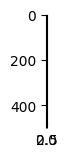

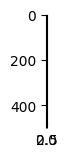

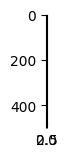

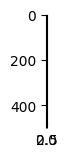

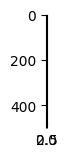

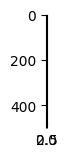

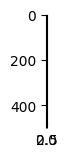

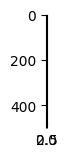

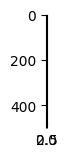

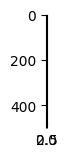

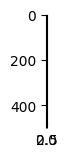

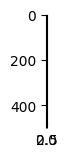

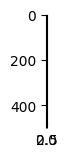

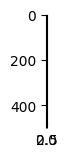

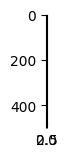

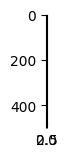

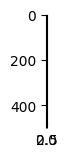

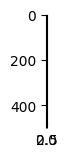

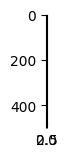

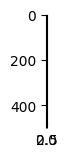

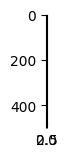

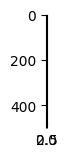

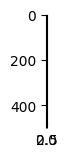

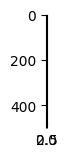

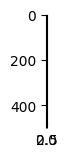

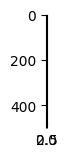

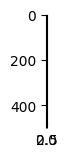

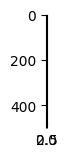

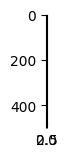

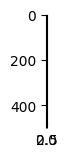

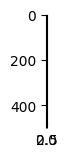

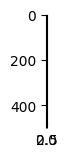

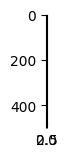

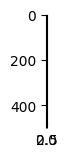

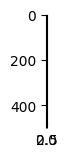

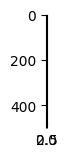

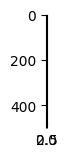

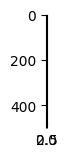

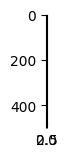

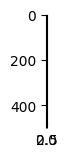

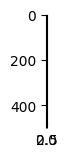

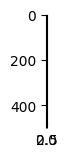

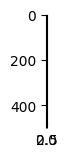

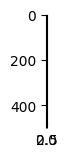

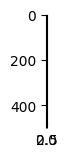

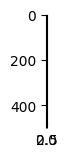

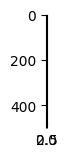

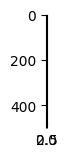

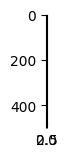

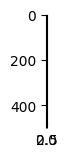

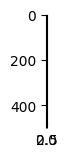

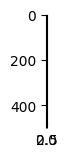

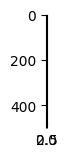

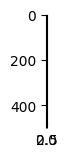

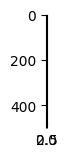

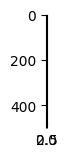

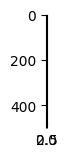

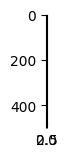

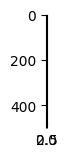

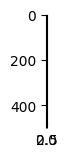

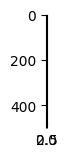

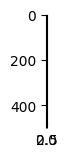

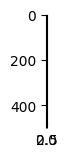

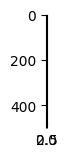

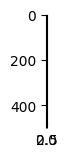

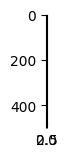

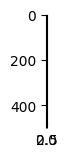

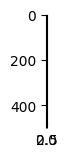

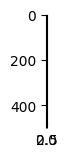

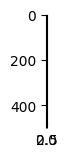

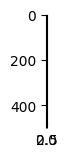

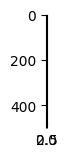

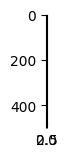

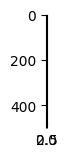

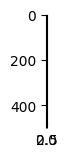

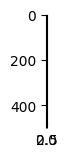

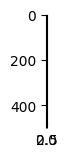

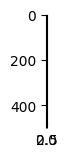

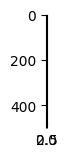

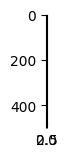

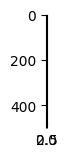

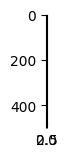

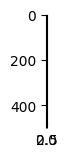

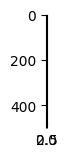

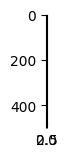

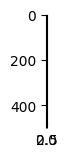

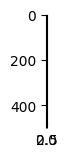

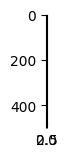

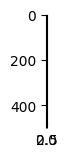

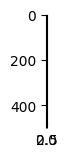

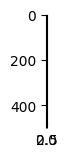

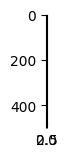

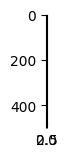

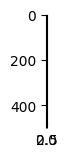

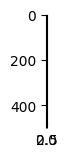

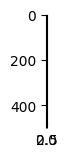

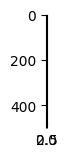

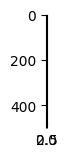

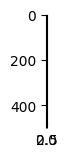

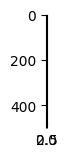

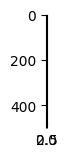

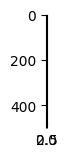

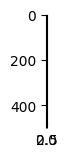

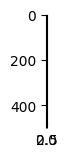

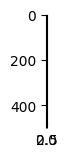

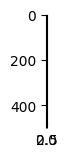

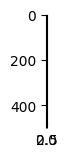

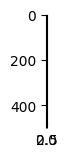

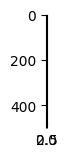

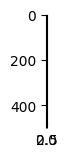

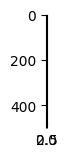

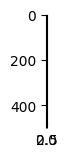

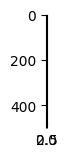

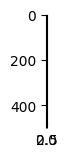

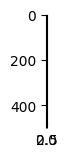

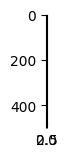

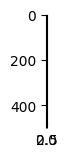

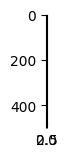

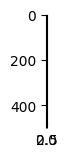

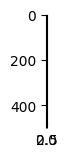

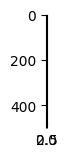

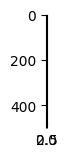

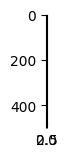

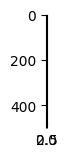

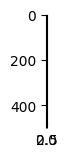

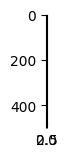

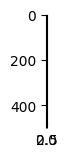

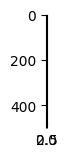

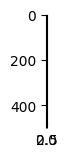

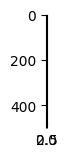

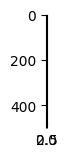

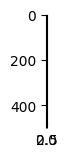

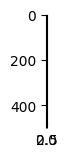

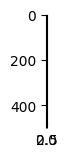

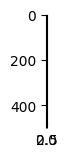

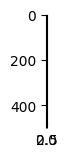

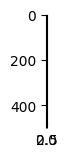

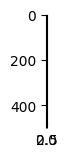

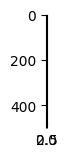

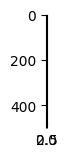

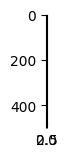

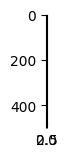

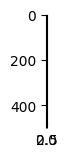

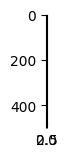

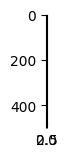

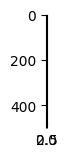

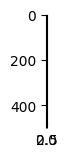

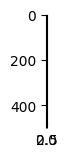

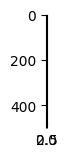

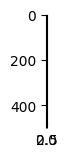

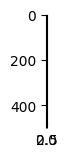

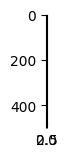

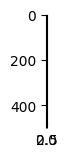

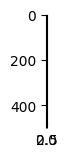

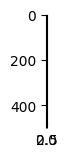

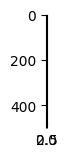

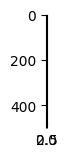

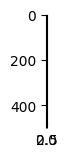

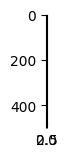

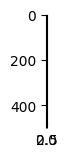

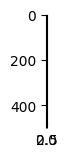

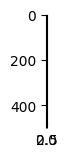

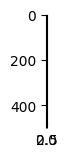

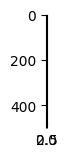

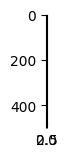

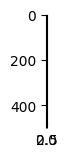

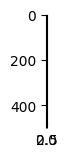

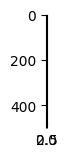

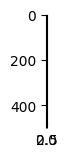

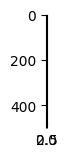

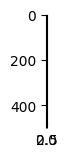

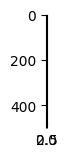

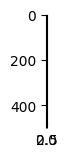

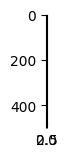

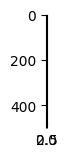

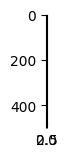

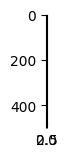

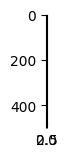

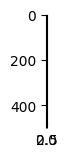

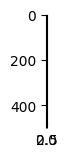

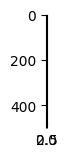

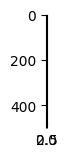

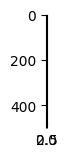

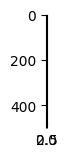

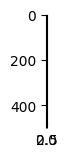

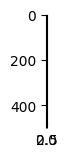

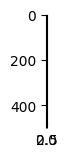

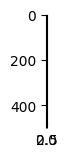

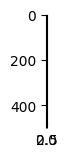

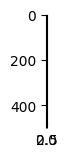

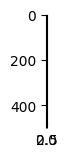

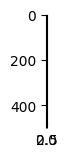

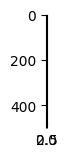

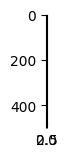

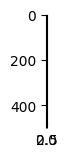

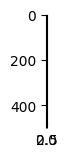

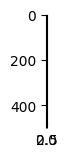

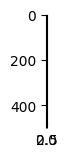

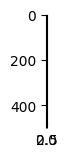

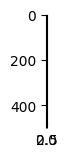

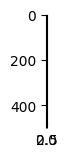

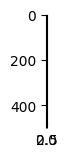

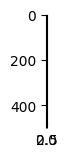

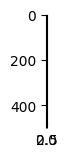

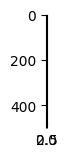

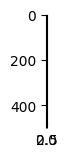

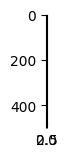

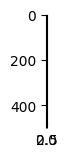

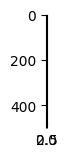

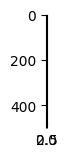

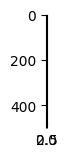

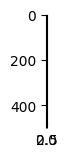

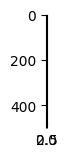

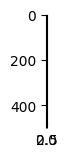

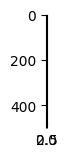

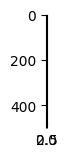

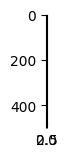

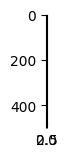

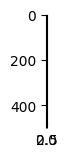

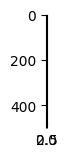

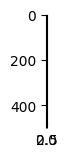

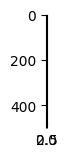

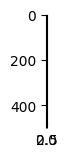

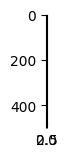

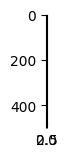

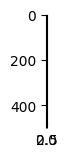

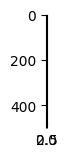

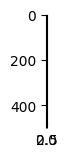

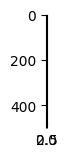

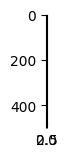

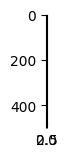

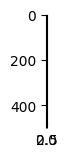

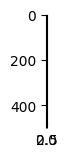

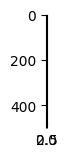

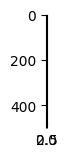

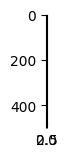

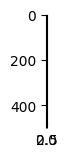

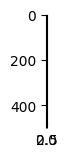

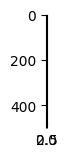

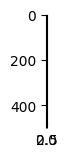

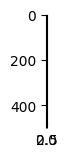

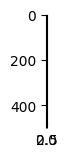

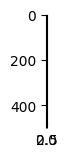

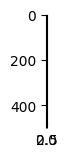

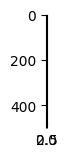

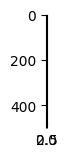

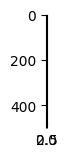

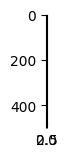

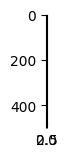

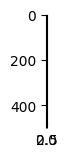

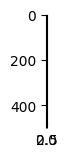

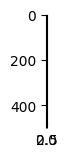

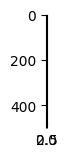

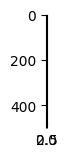

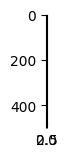

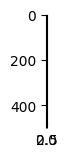

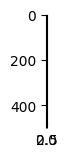

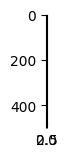

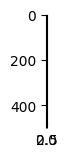

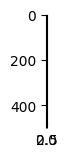

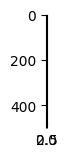

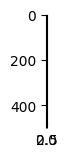

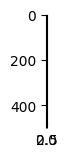

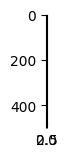

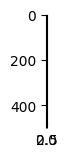

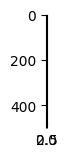

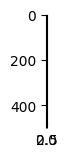

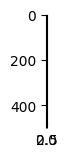

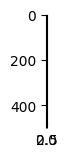

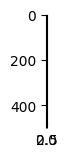

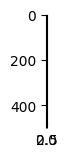

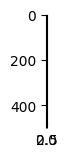

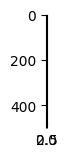

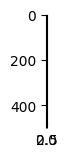

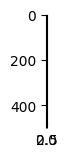

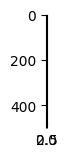

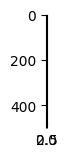

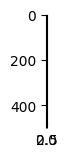

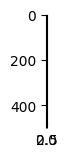

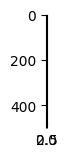

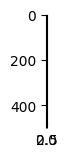

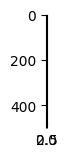

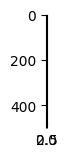

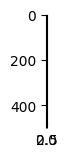

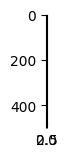

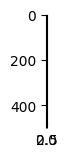

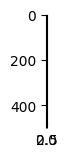

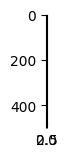

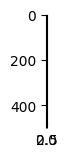

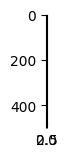

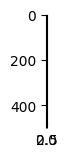

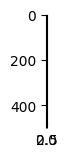

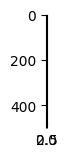

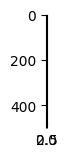

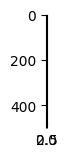

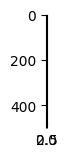

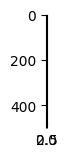

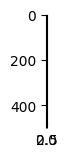

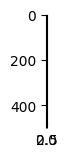

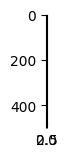

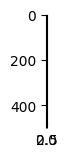

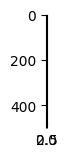

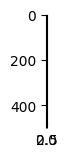

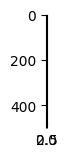

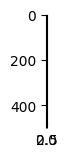

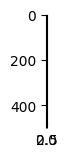

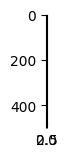

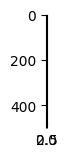

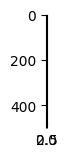

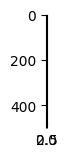

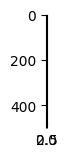

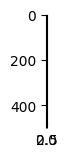

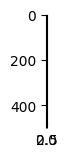

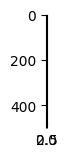

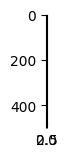

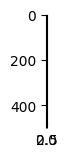

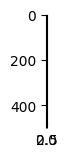

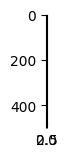

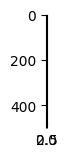

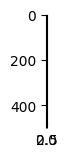

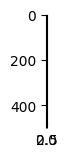

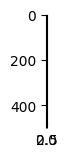

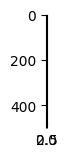

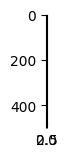

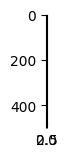

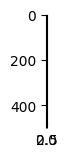

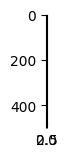

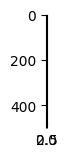

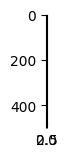

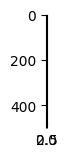

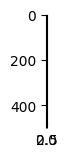

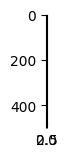

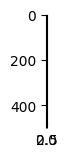

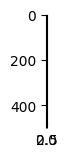

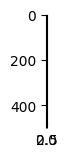

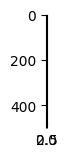

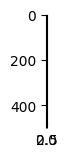

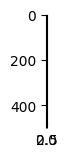

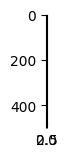

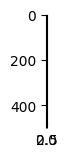

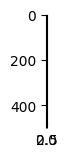

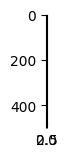

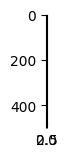

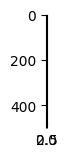

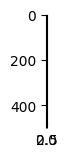

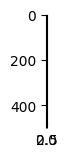

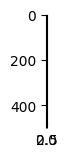

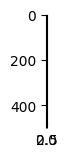

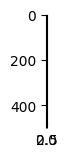

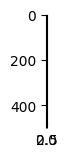

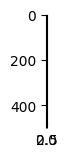

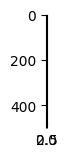

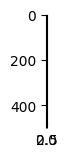

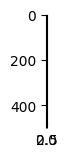

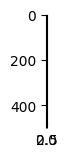

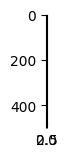

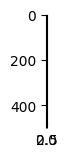

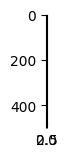

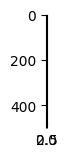

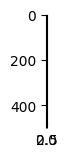

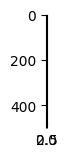

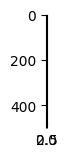

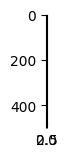

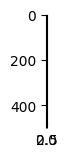

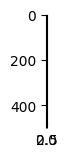

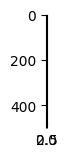

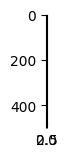

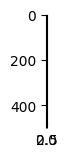

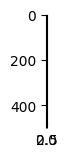

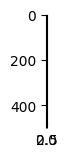

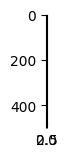

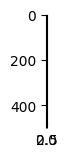

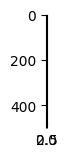

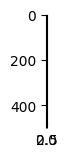

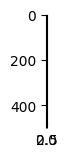

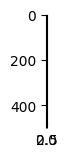

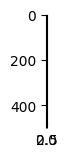

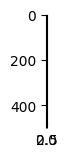

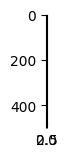

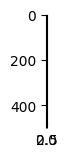

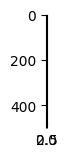

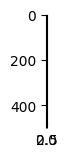

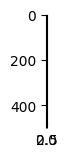

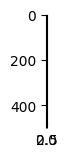

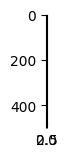

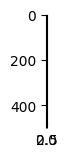

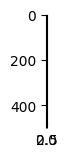

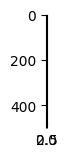

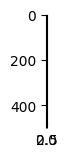

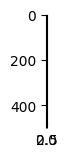

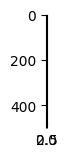

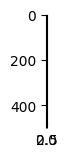

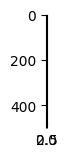

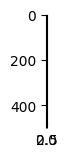

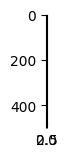

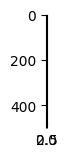

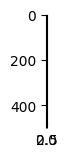

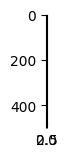

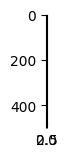

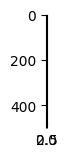

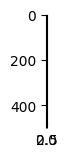

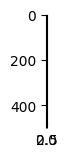

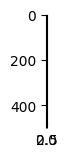

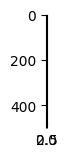

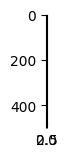

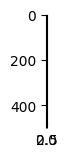

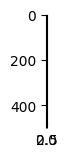

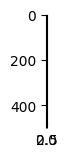

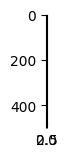

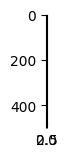

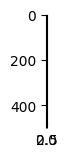

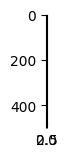

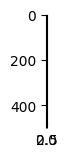

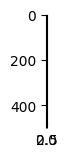

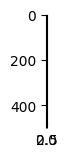

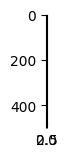

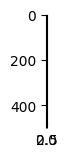

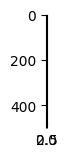

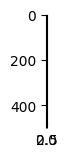

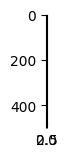

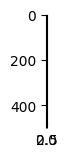

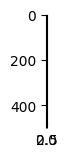

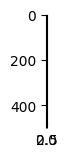

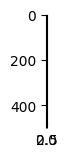

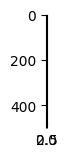

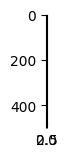

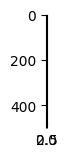

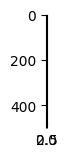

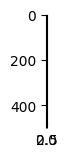

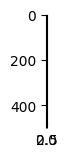

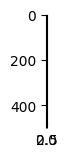

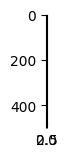

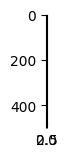

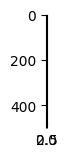

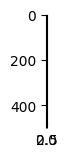

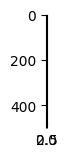

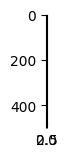

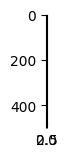

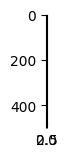

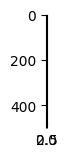

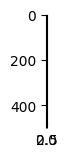

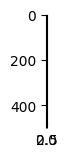

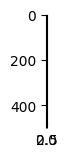

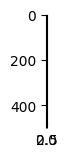

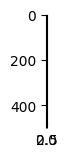

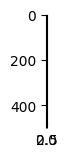

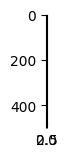

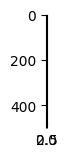

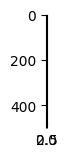

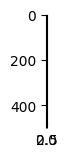

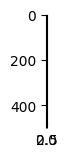

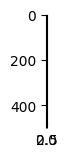

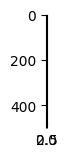

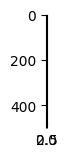

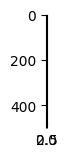

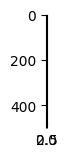

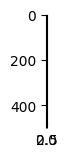

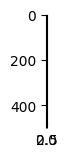

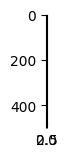

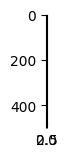

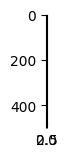

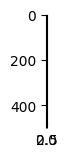

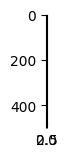

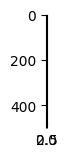

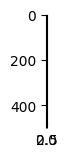

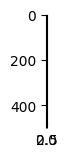

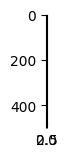

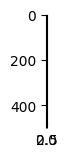

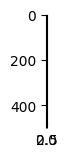

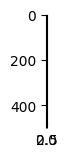

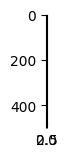

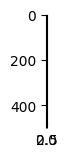

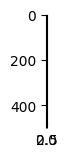

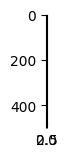

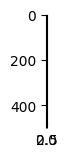

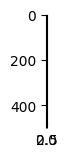

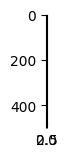

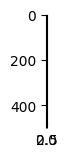

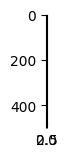

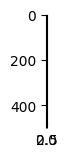

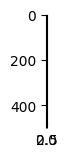

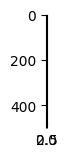

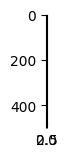

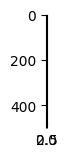

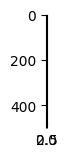

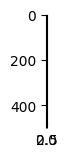

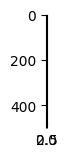

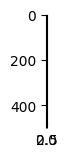

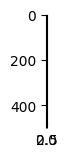

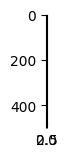

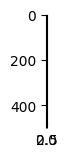

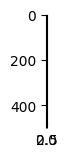

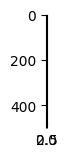

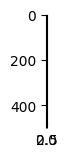

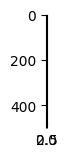

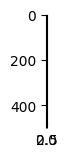

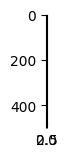

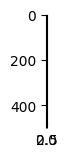

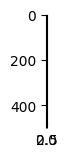

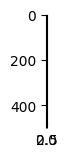

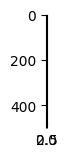

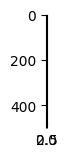

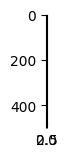

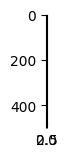

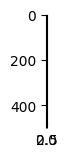

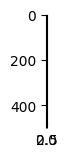

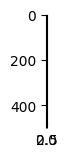

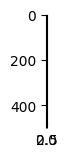

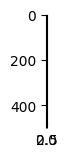

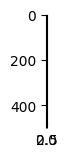

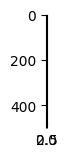

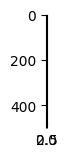

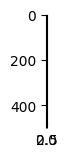

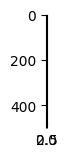

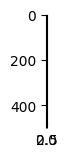

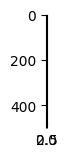

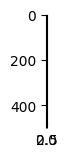

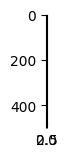

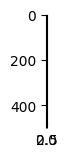

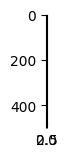

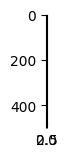

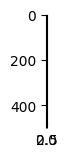

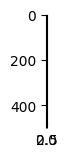

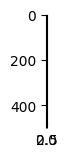

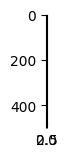

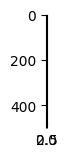

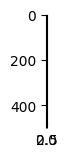

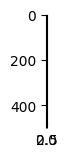

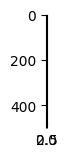

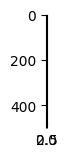

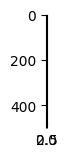

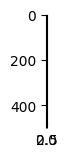

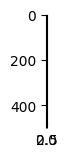

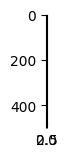

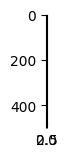

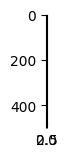

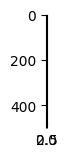

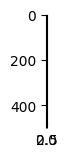

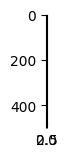

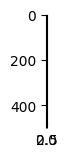

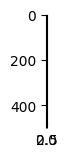

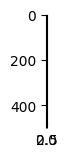

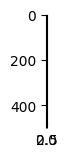

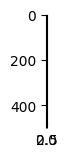

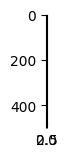

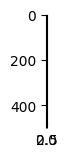

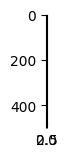

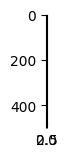

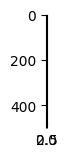

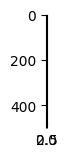

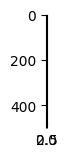

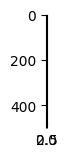

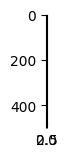

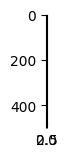

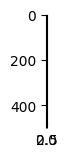

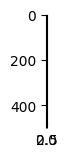

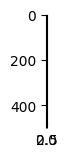

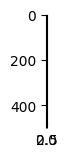

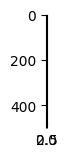

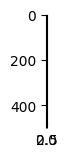

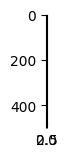

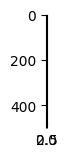

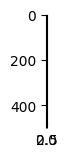

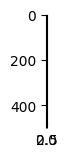

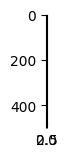

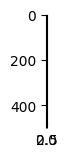

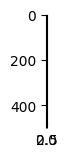

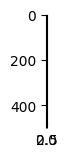

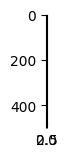

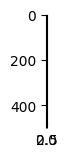

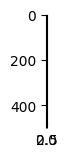

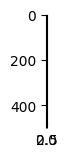

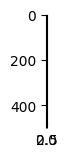

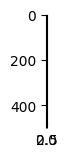

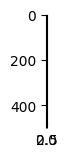

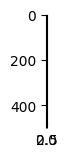

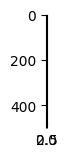

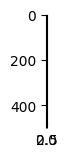

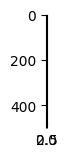

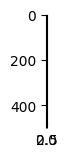

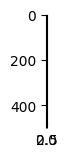

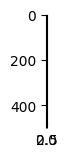

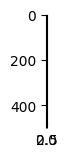

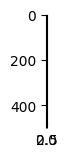

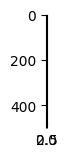

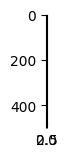

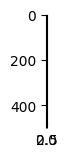

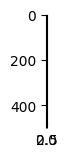

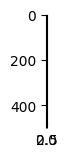

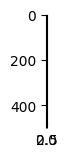

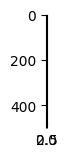

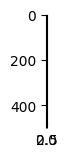

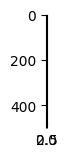

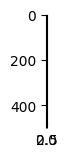

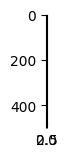

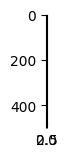

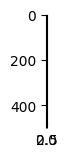

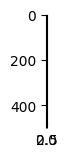

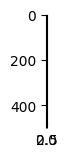

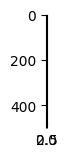

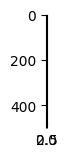

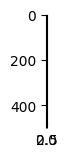

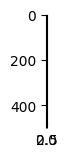

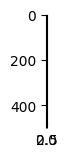

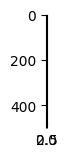

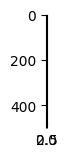

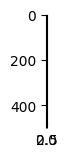

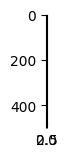

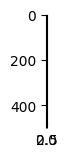

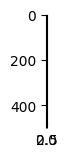

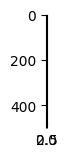

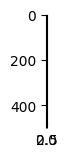

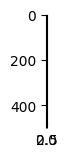

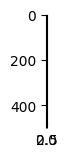

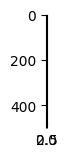

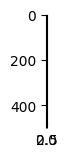

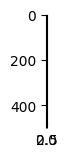

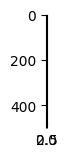

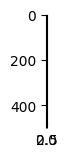

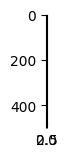

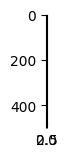

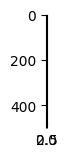

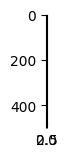

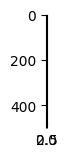

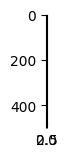

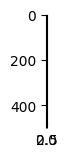

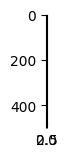

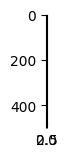

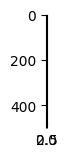

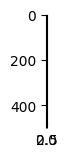

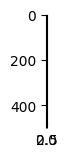

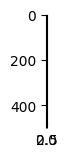

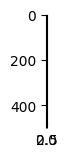

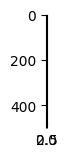

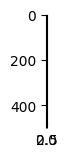

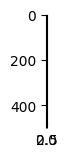

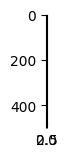

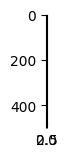

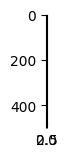

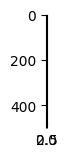

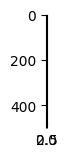

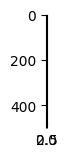

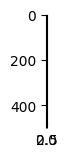

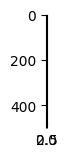

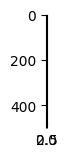

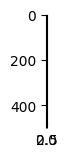

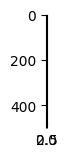

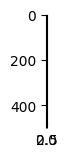

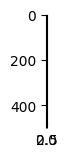

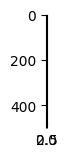

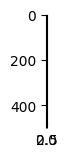

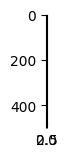

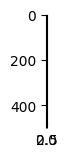

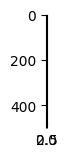

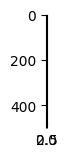

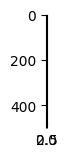

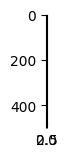

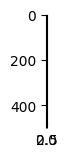

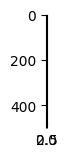

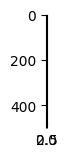

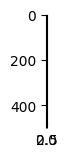

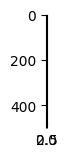

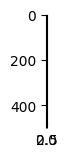

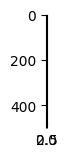

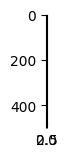

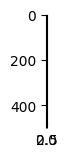

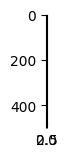

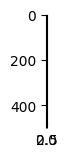

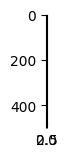

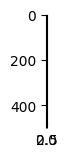

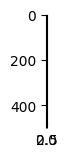

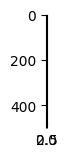

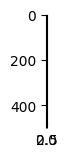

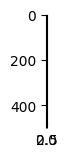

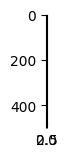

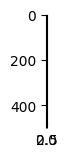

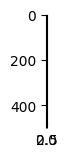

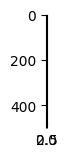

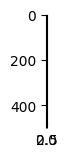

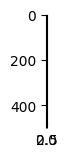

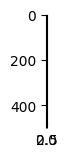

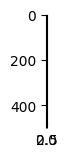

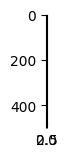

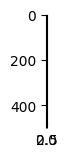

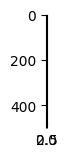

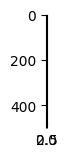

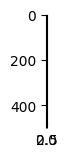

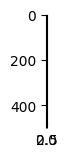

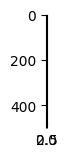

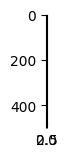

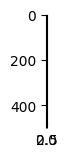

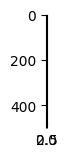

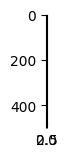

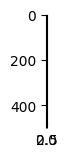

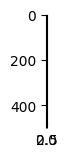

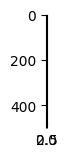

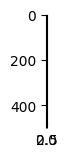

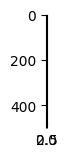

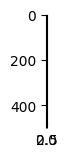

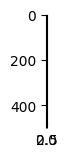

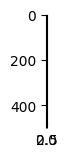

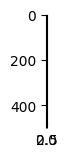

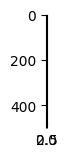

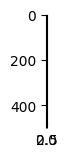

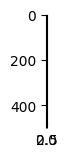

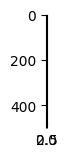

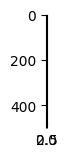

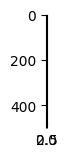

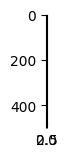

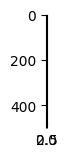

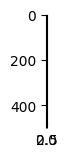

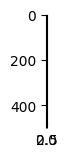

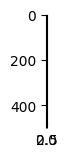

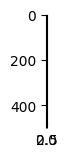

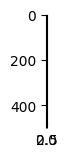

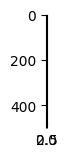

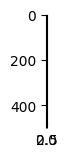

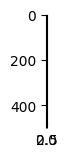

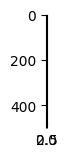

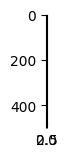

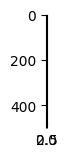

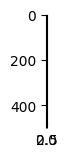

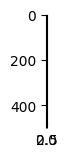

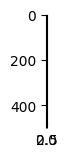

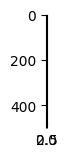

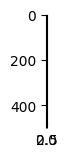

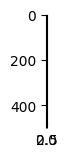

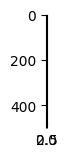

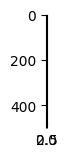

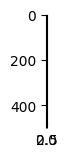

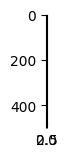

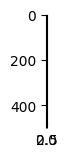

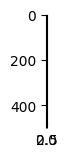

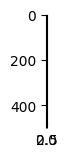

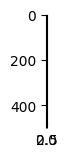

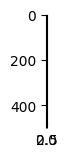

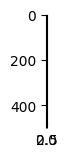

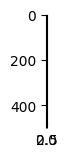

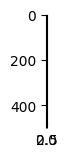

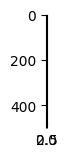

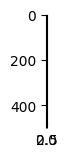

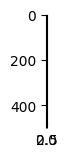

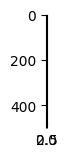

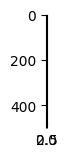

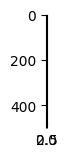

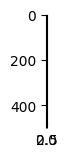

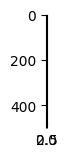

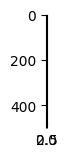

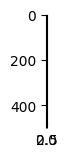

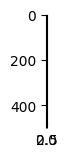

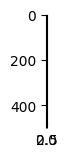

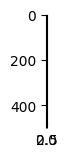

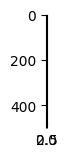

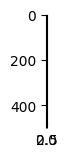

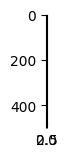

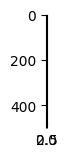

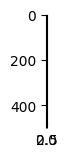

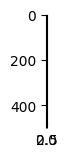

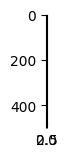

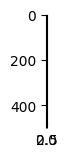

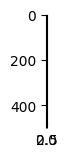

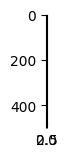

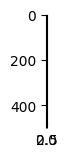

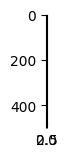

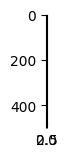

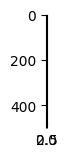

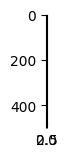

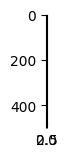

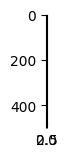

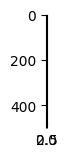

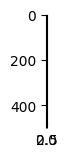

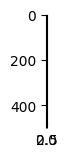

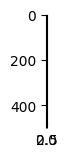

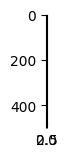

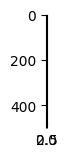

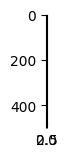

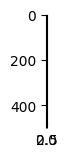

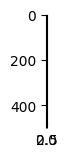

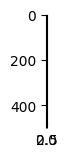

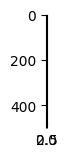

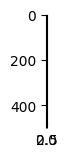

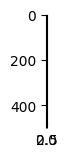

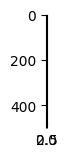

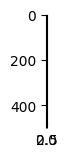

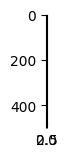

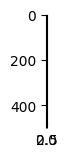

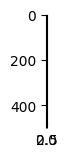

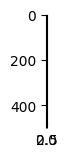

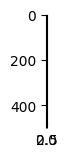

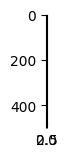

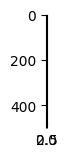

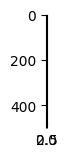

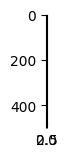

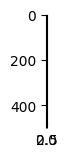

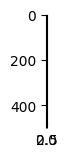

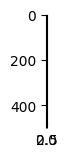

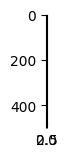

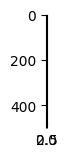

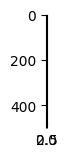

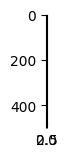

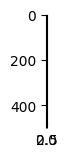

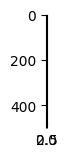

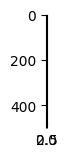

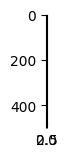

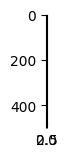

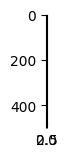

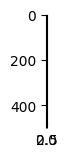

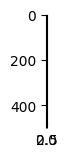

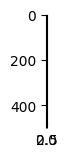

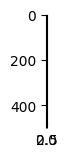

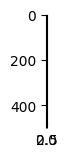

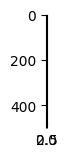

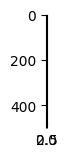

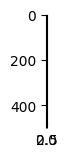

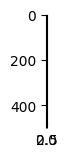

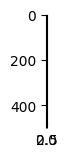

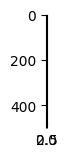

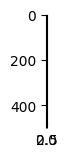

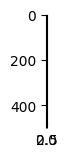

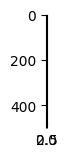

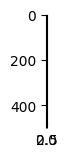

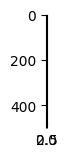

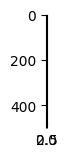

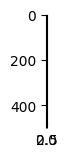

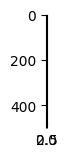

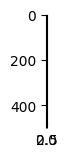

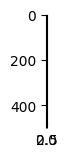

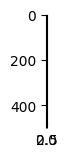

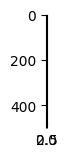

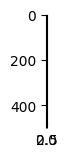

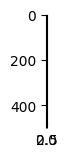

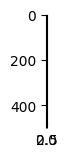

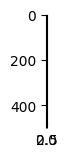

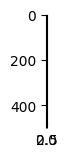

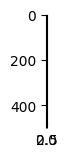

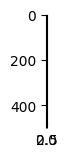

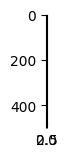

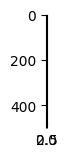

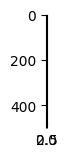

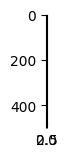

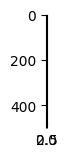

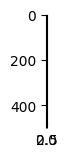

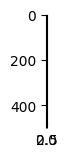

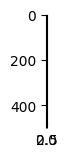

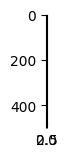

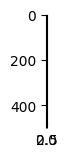

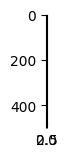

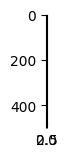

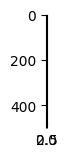

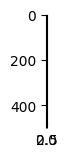

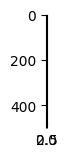

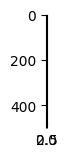

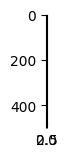

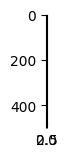

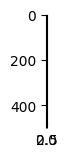

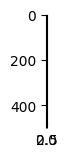

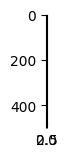

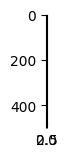

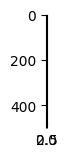

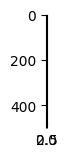

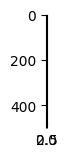

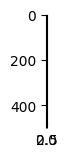

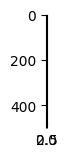

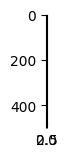

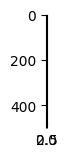

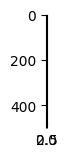

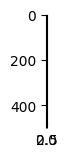

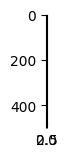

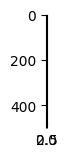

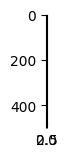

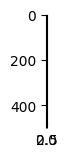

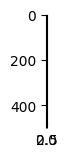

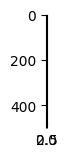

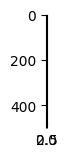

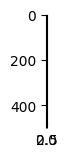

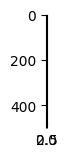

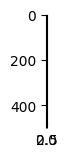

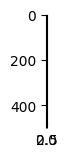

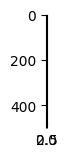

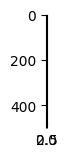

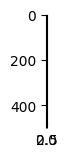

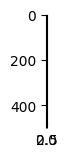

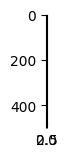

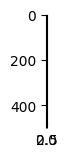

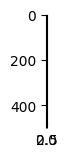

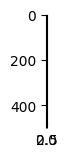

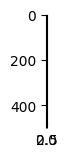

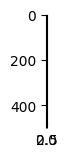

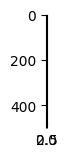

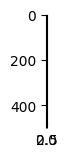

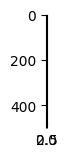

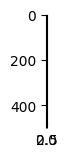

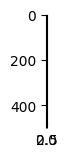

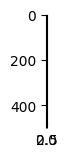

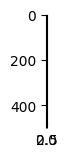

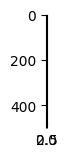

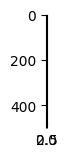

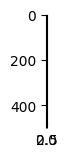

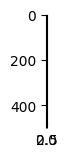

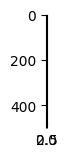

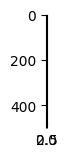

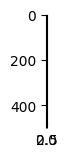

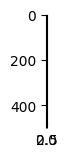

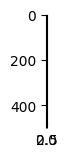

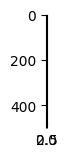

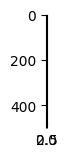

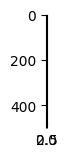

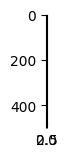

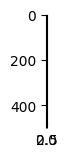

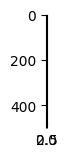

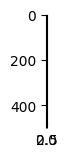

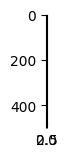

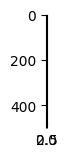

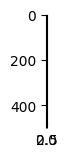

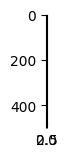

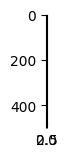

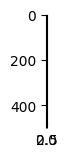

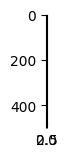

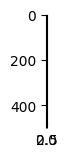

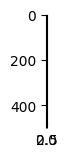

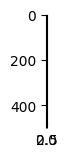

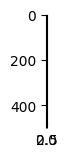

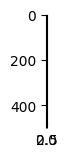

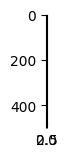

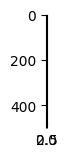

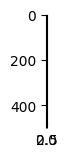

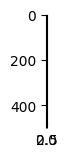

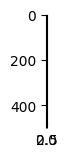

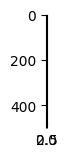

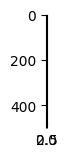

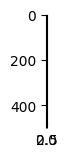

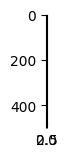

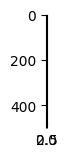

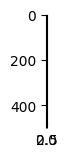

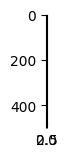

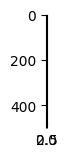

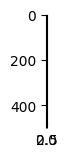

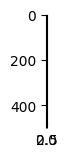

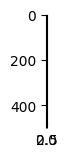

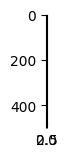

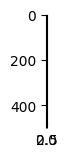

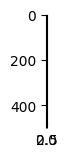

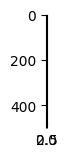

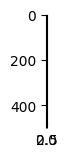

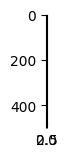

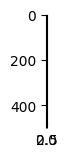

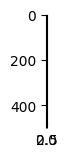

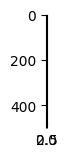

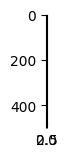

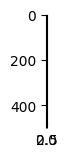

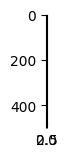

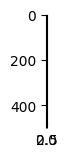

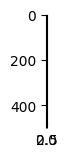

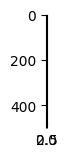

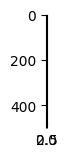

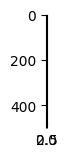

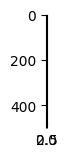

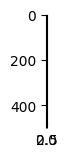

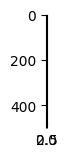

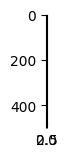

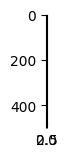

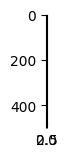

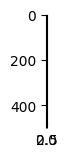

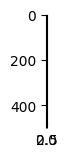

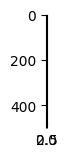

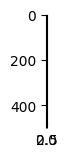

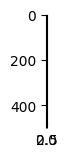

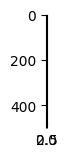

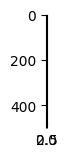

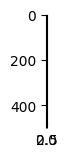

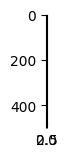

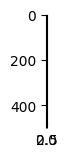

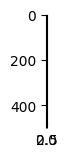

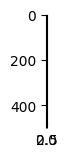

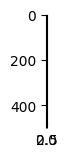

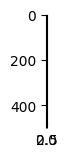

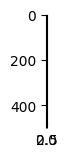

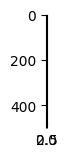

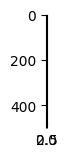

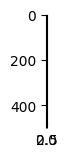

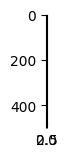

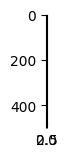

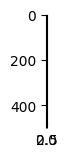

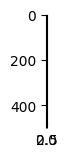

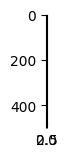

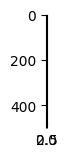

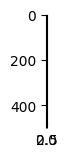

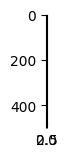

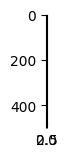

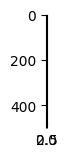

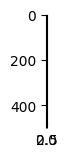

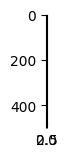

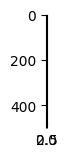

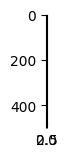

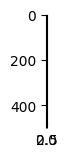

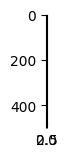

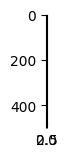

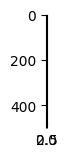

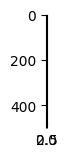

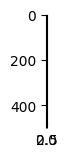

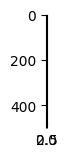

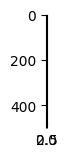

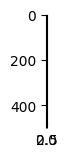

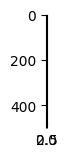

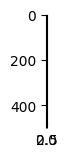

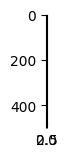

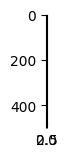

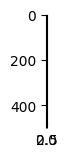

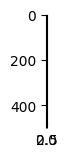

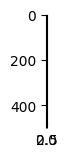

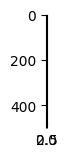

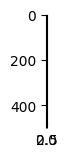

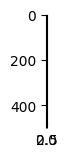

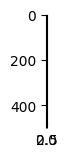

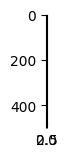

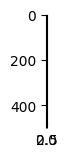

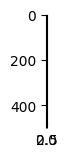

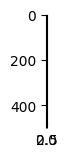

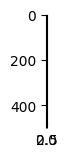

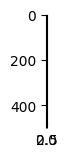

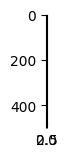

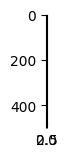

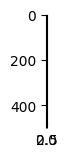

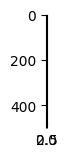

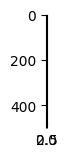

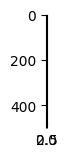

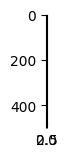

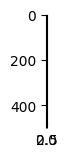

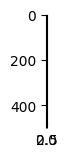

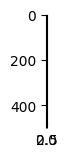

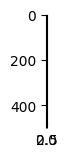

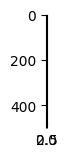

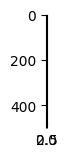

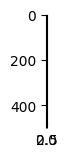

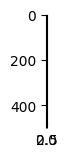

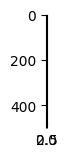

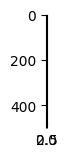

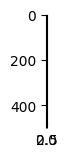

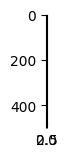

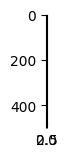

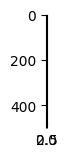

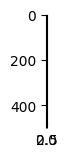

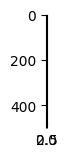

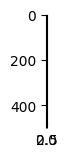

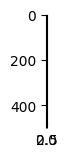

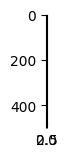

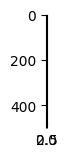

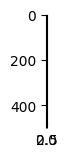

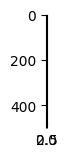

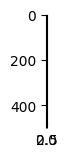

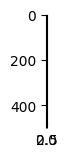

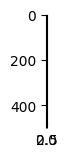

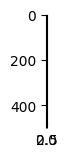

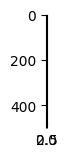

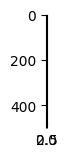

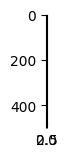

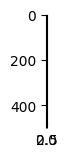

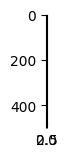

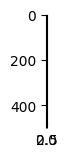

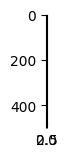

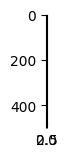

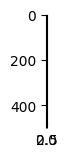

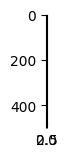

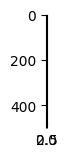

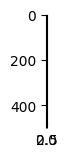

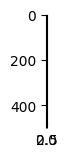

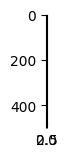

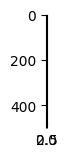

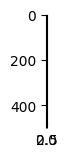

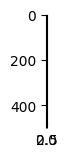

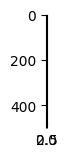

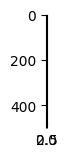

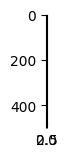

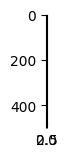

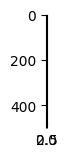

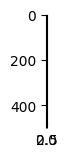

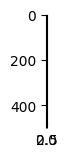

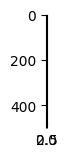

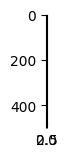

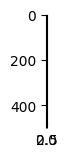

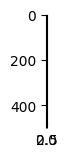

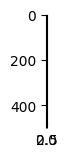

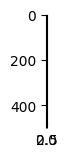

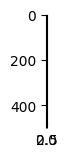

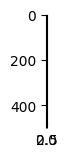

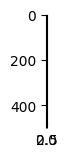

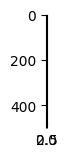

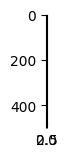

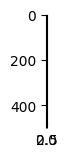

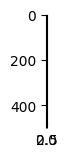

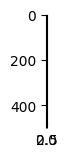

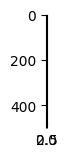

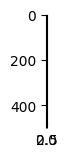

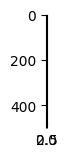

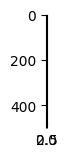

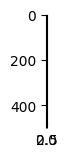

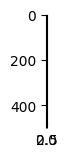

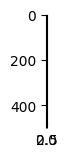

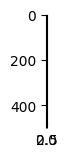

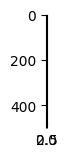

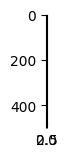

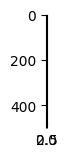

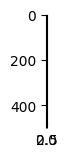

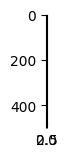

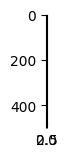

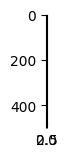

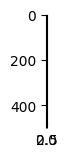

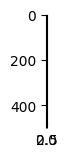

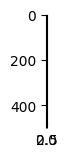

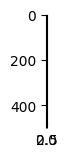

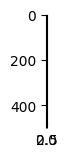

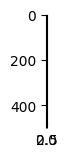

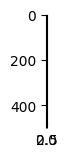

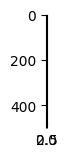

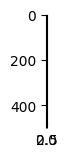

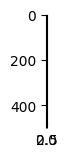

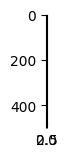

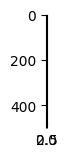

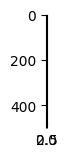

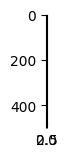

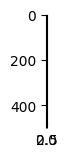

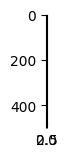

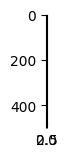

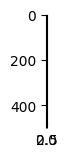

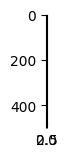

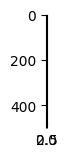

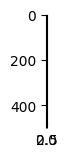

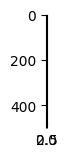

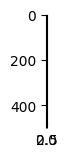

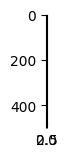

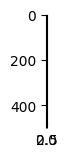

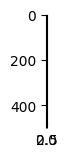

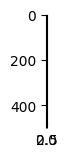

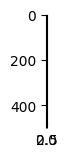

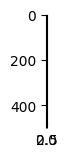

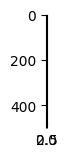

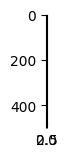

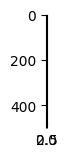

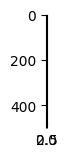

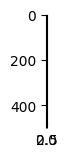

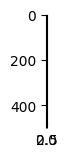

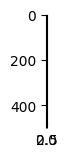

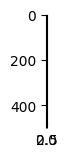

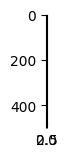

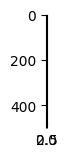

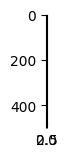

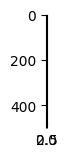

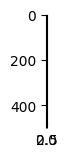

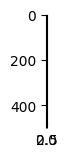

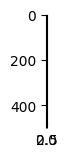

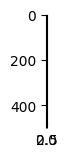

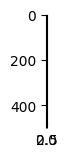

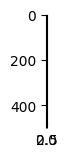

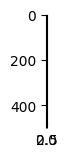

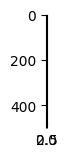

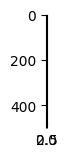

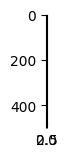

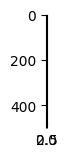

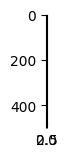

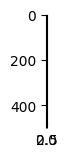

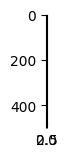

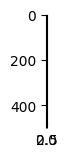

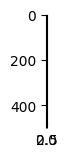

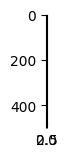

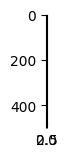

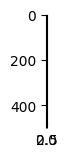

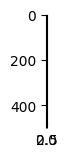

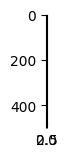

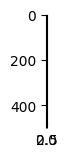

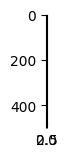

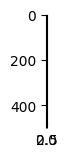

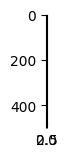

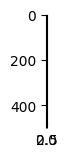

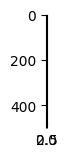

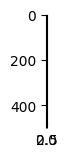

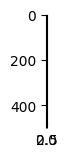

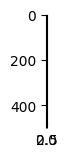

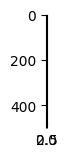

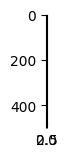

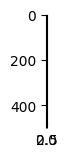

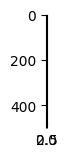

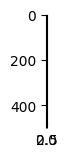

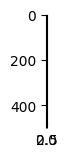

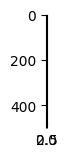

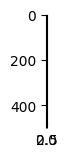

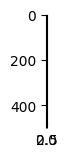

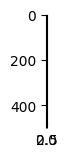

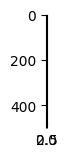

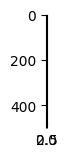

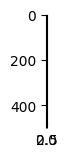

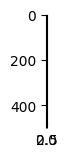

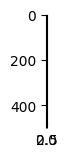

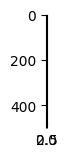

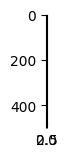

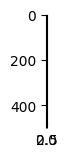

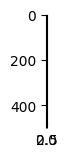

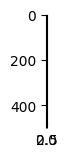

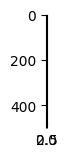

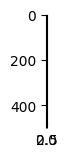

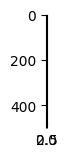

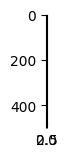

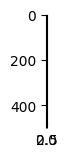

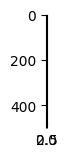

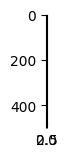

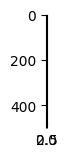

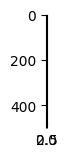

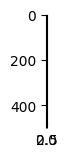

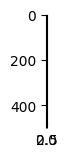

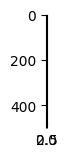

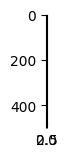

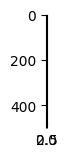

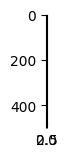

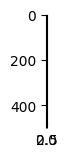

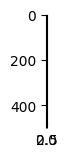

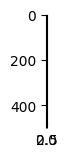

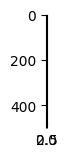

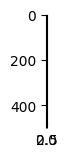

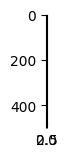

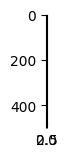

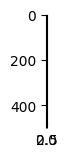

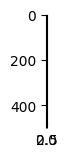

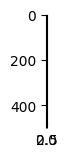

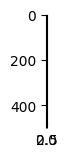

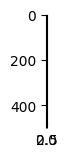

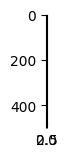

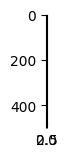

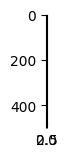

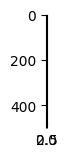

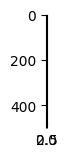

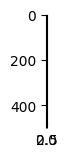

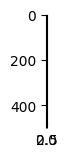

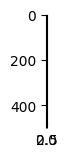

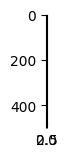

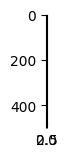

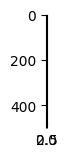

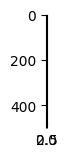

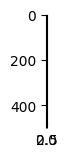

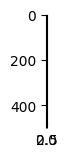

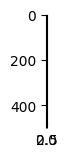

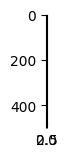

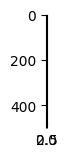

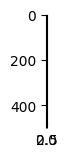

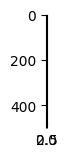

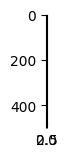

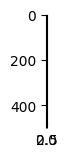

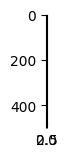

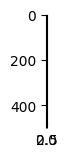

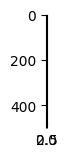

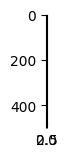

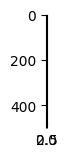

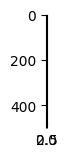

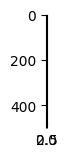

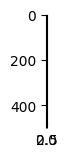

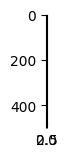

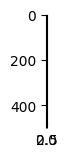

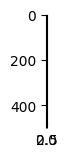

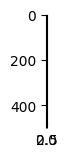

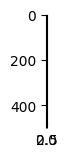

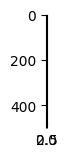

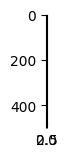

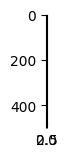

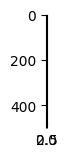

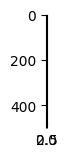

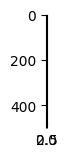

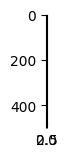

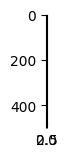

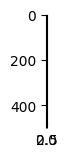

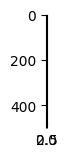

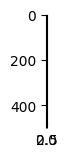

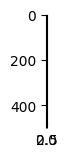

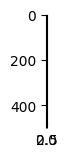

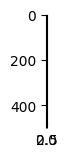

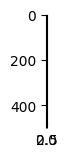

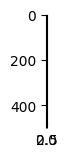

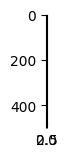

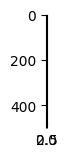

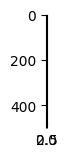

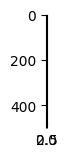

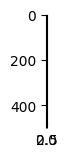

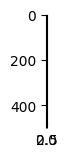

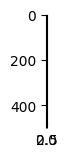

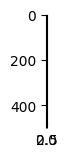

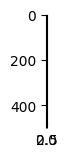

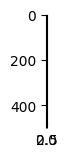

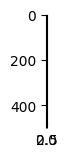

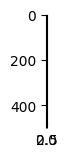

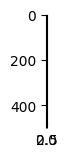

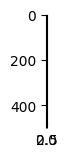

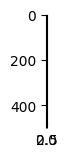

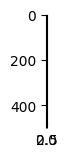

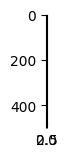

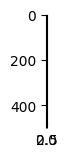

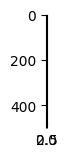

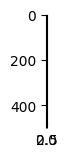

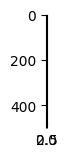

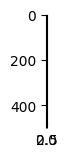

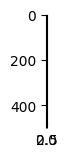

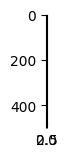

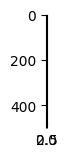

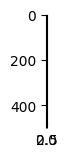

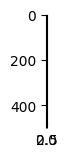

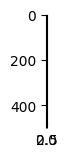

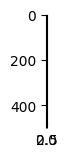

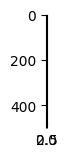

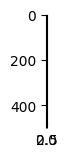

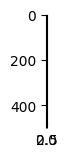

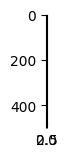

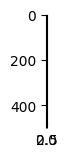

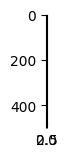

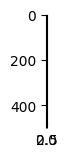

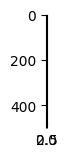

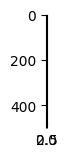

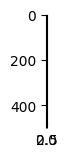

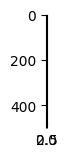

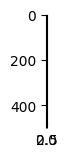

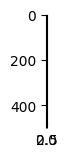

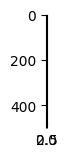

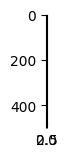

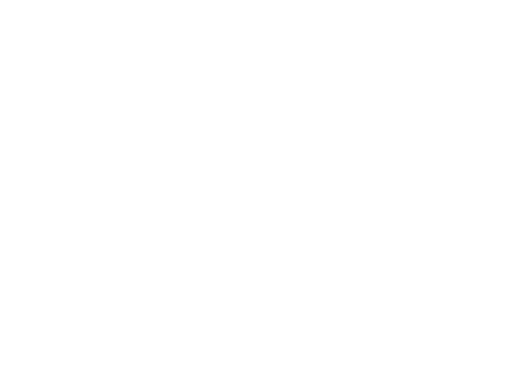

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in image_batch:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], interpolation='nearest')
    plt.show()
    plt.axis("off")

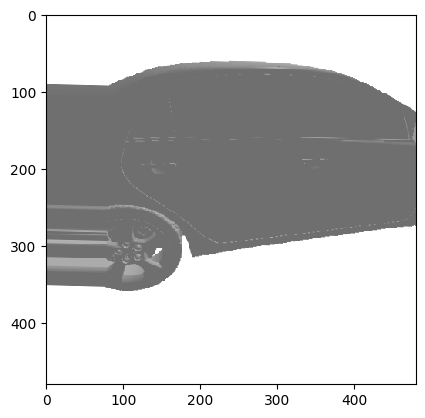

In [31]:
from matplotlib import pyplot as plt

#for images in image_batch:
plt.imshow(images[0], interpolation='nearest')
plt.show()

In [11]:
## Set TensorBoard 
root_logdir = '/media/SSD/Data_photogram_Pcar/EffnetV2Model/R1/Nfold-1/Mylogs_tensor/'  ##เปลี่ยน path 
if not os.path.exists(root_logdir) :
    os.makedirs(root_logdir)
    
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)
run_logdir = get_run_logdir()

tensorboard_cb = callbacks.TensorBoard(log_dir = run_logdir)

In [12]:
#Training model    
model.compile(
    optimizer= optimizers.Adam(learning_rate=0.00002),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


checkpoint_filepath = '/media/SSD/Data_photogram_Pcar/EffnetV2Model/R1/Nfold-1/checkpoint/' ### เปลี่ยน path
if not os.path.exists(checkpoint_filepath) :
        os.makedirs(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath, save_freq='epoch', ave_weights_only=False)

In [ ]:
## Fit model 
model.fit(train_generator,
    epochs=3,
    validation_data=valid_generator,
    callbacks = [tensorboard_cb, model_checkpoint_callback])

In [ ]:
##Save model as TFLiteConverter
modelName = 'EffnetV2m_R1_3DCAR15p_Nfold1'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Pth_model_save = '/media/SSD/Data_photogram_Pcar/EffnetV2Model/R1/Nfold-1/models/'  ##เปลี่ยน path 
if not os.path.exists(Pth_model_save) :
    os.makedirs(Pth_model_save)

# Save model as .tflite
with open(f"{Pth_model_save}{modelName}.tflite", "wb") as file:
      file.write(tflite_model)
# Save model as .h5        
model.save(f'{Pth_model_save}{modelName}.h5') 
print(f'Save Model as [ {Pth_model_save}{{modelName}}.h5 ]')

--------------------------------------------------------

### Check Images extensions

In [3]:
import os
from PIL import Image
import cv2

folder_path = '/media/SSD/Data_photogram_Pcar/8-Fold'
extensions = []
# for fldr in os.listdir(folder_path):
#     sub_folder_path = os.path.join(folder_path, fldr)
#     print(sub_folder_path)
for filee in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filee)
    im = cv2.imread(file_path)
    #print('** Path: {}  **'.format(file_path), end="\r", flush=True)
    try:
        ih, iw, _ = im.shape
    except:
        extensions.append(file_path)
        print(file_path)
#     if image is None :
#         print(file_path)
        #extensions.append(file_path)
#     rgb_im = im.convert('RGB')
#     if filee.split('.')[1] not in extensions:
#         extensions.append(filee.split('.')[1])

libpng error: IDAT: CRC error
libpng error: IDAT: incorrect data check


In [4]:
print(len(extensions))
extensions

163862


['/media/SSD/Data_photogram_Pcar/8-Fold/id26-Moderate_p6_dis1.5O2_angle287L1_elev30U3.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id14-Base_p15_dis1.8I2_angle0_elev110D2.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id26-Moderate_p4_dis1.8O3_angle317R2_elev15U3.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id14-Base_p9_dis1.65I3_angle107_elev30.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id13-Minor_p11_dis1.7I5_angle137R3_elev15U4.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id26-Minor_p11_dis1.75_angle137R2_elev15.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id13-Severe_p3_dis1.8O2_angle43R1_elev15U1.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id26-Minor_p13_dis1.85I1_angle180L3_elev15D4.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id26-Severe_p8_dis1.75O1_angle320_elev30D3.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id26-Minor_p10_dis1.65O2_angle253L1_elev30.png',
 '/media/SSD/Data_photogram_Pcar/8-Fold/id14-Moderate_p11_dis1.75_angle137L4_elev15D3.png',
 '/media/SSD/Data_

In [9]:
img_extensions = pd.DataFrame(extensions, columns =['path_train'])
print(img_extensions.shape)
img_extensions.head()

(163862, 1)


path_train
0  /media/SSD/Data_photogram_Pcar/8-Fold/id26-Mod...
1  /media/SSD/Data_photogram_Pcar/8-Fold/id14-Bas...
2  /media/SSD/Data_photogram_Pcar/8-Fold/id26-Mod...
3  /media/SSD/Data_photogram_Pcar/8-Fold/id14-Bas...
4  /media/SSD/Data_photogram_Pcar/8-Fold/id13-Min...

In [ ]:
with open(f'{f_name_toSave}/{txt_name}-demo.txt', 'w') as f:
         for line in list_path:
             f.write(f"{line}\n")

In [10]:
img_extensions.to_csv('/media/SSD/Data_photogram_Pcar/3DCar_img_extensions.csv')

### ย้าย image ใหม่

In [ ]:
# columns = list(database.columns)
# df0_ = pd.DataFrame(columns=columns)
df0_ = []
extensions_ = img_extensions['path_train'].tolist()
for p in extensions_:
    df0 = database[database['path_train'] == p]
    #df0_ = df0_.append(df0)
    df0_.append(df0)

## Concat df     
df_all = pd.concat(df0_)
print(df_all.shape)
df_all.head()

In [17]:
df0_

Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, ID, Damage, p, FileName, distance, Angle, img_path, Fold, path_train]
Index: []

In [ ]:
import shutil as sh
import time

path2save = '/media/SSD/Data_photogram_Pcar/8-Fold/'
fold0 = list(set(Table_path_['Fold']))
fold0.sort()
for i in range(len(fold0)):
    df0 = Table_path_[Table_path_['Fold'] == fold0[i]]
    path_img = df0['img_path'].tolist()
    name_img = df0['FileName'].tolist()
    if not os.path.exists('{}'.format(path2save)) :
             os.makedirs('{}'.format(path2save))
    for j in range(len(path_img)):
        sh.copy("{}".format(path_img[j]),"{}{}".format(path2save, name_img[j]))
    print(f'On process Copy at fold -->> [ {fold0[i]} ] ')
    print('-'*100)
    time.sleep(5)    

In [7]:
#file_path

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import random

# ims = random.choices(file, k=5)
# for im in ims:
#     #print(im)
#     name_im = im.split('/')[-1]
#     #print(name_im)
im = '/media/SSD/Data_photogram_Pcar/8-Fold/id26-Moderate_p6_dis1.5O2_angle287L1_elev30U3.png'
name_im = im.split('/')[-1]
image = cv2.imread(im)
if image == None :
    print(f'Image Cannot Open')
# sZ = os.path.getsize(im)
# #print(f"Images Name : **{name_im}, --> Shape ", image.shape)
# print(f"image size: {sZ:,} bytes")
# plt.axis("off")
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.show()

Image Cannot Open


In [43]:
im0 = database[database['path_train'] == '/media/SSD/Data_photogram_Pcar/8-Fold/id26-Moderate_p6_dis1.5O2_angle287L1_elev30U3.png']
im0

Unnamed: 0.1  Unnamed: 0    ID    Damage   p  \
281829        281829      281829  id26  Moderate  p6   

                                                 FileName  distance  \
281829  id26-Moderate_p6_dis1.5O2_angle287L1_elev30U3.png  dis1.5O2   

             Angle                                           img_path    Fold  \
281829  Angle287L1  /media/SSD/Data_photogram_car/id26/Moderate/p6...  fold-8   

                                               path_train  
281829  /media/SSD/Data_photogram_Pcar/8-Fold/id26-Mod...

In [44]:
im0['img_path'].tolist()

['/media/SSD/Data_photogram_car/id26/Moderate/p6/dis1.5O2/Angle287L1/id26-Moderate_p6_dis1.5O2_angle287L1_elev30U3.png']

In [5]:
#im = '/media/SSD/Data_photogram_car/id26/Moderate/p6/dis1.5O2/Angle287L1/id26-Moderate_p6_dis1.5O2_angle287L1_elev30U3.png'
im = '/media/SSD/Data_photogram_Pcar/8-Fold/id14-Minor_p6_dis1.5I2_angle287_elev30.png'
name_im = im.split('/')[-1]
image = cv2.imread(im)
#image
if image is None :
    print(f'Image Cannot Open')
else:
    sZ = os.path.getsize(im)
    print(f"Images Name : **{name_im}, --> Shape ", image.shape)
    print(f"image size: {sZ:,} bytes")
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Image Cannot Open


In [6]:
image

In [24]:
os.listdir(folder_path)

['id6-Base_p13_dis1.95O3_angle180L1_elev15D1.png',
 'id2-Moderate_p11_dis1.7I2_angle137_elev15.png',
 'id6-Base_p4_dis1.8I3_angle317R1_elev15.png',
 'id26-Moderate_p6_dis1.5O2_angle287L1_elev30U3.png',
 'id14-Base_p15_dis1.8I2_angle0_elev110D2.png',
 'id12-Moderate_p13_dis1.85O4_angle180L3_elev15D3.png',
 'id2-Moderate_p2_dis1.8I1_angle0L1_elev20.png',
 'id2-Minor_p2_dis1.8O1_angle0R4_elev20D3.png',
 'id26-Moderate_p4_dis1.8O3_angle317R2_elev15U3.png',
 'id14-Base_p9_dis1.65I3_angle107_elev30.png',
 'id13-Minor_p11_dis1.7I5_angle137R3_elev15U4.png',
 'id26-Minor_p11_dis1.75_angle137R2_elev15.png',
 'id8-Moderate_p11_dis1.75_angle137L3_elev15U4.png',
 'id13-Severe_p3_dis1.8O2_angle43R1_elev15U1.png',
 'id26-Minor_p13_dis1.85I1_angle180L3_elev15D4.png',
 'id12-Moderate_p8_dis1.75I3_angle320R1_elev30D4.png',
 'id26-Severe_p8_dis1.75O1_angle320_elev30D3.png',
 'id6-Moderate_p6_dis1.5O2_angle287L3_elev30D1.png',
 'id2-Moderate_p12_dis1.7O3_angle223_elev15U3.png',
 'id2-Severe_p7_dis1.7I4_an

In [25]:
file_path

'/media/SSD/Data_photogram_Pcar/8-Fold/id6-Minor_p2_dis1.9O5_angle0R1_elev20D1.png/id6-Base_p13_dis1.95O3_angle180L1_elev15D1.png'

In [27]:
file_path

'/media/SSD/Data_photogram_Pcar/8-Fold/id26-Moderate_p6_dis1.5O2_angle287L1_elev30U3.png'